# **NiLeMativ Group**



*   Begovic Ivan
*   Bombini Nicola
*   Iania Leonardo
*   Leite Matheus



> Import of the necessary libraries:

In [9]:
%%capture
!pip install transformers
!pip install wandb
!pip install keras-preprocessing

In [10]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from google.colab import drive
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Input, Reshape, Dropout
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import NMF, LatentDirichletAllocation, IncrementalPCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from string import ascii_uppercase, ascii_lowercase 
from keras.layers import Bidirectional
import torch
from tqdm import tqdm
import transformers
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
import wandb
from wordcloud import WordCloud, STOPWORDS



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. **Project summary**

## 0.1 **Objective:**

Our group has been working with the categorization of 19997 texts in 20 different topics, according to their content. This is a multi-label classification task and we tried different methods in order to obtain a good accuracy.

The methods we used were:
* Machine Learning based
  * Multinomial Naïve Bayes
  * Linear SVC
* Neural Network based
  * LSTM
  * BiLSTM
* Transformer based
  * BERT
  * RoBERTa



In the end we compared the performance of each method and decided which one performed the best on our data.

## 0.2 **The Data:**

>A Usenet newsgroup is a repository usually within the Usenet (a worldwide distributed discussion system available on computers, implemented in the '80s) system, for messages posted from users in different locations using the Internet. They are discussion groups and are not devoted to publishing news. Newsgroups are technically distinct from, but functionally similar to, discussion forums on the World Wide Web.
>
>Before the adoption of the World Wide Web, Usenet newsgroups were among the most popular Internet services, and have retained their noncommercial nature in contrast to the increasingly ad-laden web. In recent years, this form of open discussion on the Internet has lost considerable ground to individually-operated browser-accessible forums and big media social networks such as Facebook and Twitter.
>


>The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups (we will look at the distribution later: the classes are well balanced). The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.
>
>The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). 
>
>The data available here are in .tar.gz bundles. We needed need tar and gunzip to open them. Each subdirectory in the bundle represents a newsgroup; each file in a subdirectory is the text of some newsgroup document that was posted to that newsgroup.
>
>There were three versions of the data set. The first ("19997") is the original, unmodified version: we decided to use that and perform train-test splits on our own instead of using the ones provided in the other versions.


# 1. **Data Preparation and Exploratory Analysis**

## 1.1. **Data Loading and Preparation**

>First things first, we needed to read the documents we had to work with, from Google Drive, since we decided to work on Colab. Hence, we mounted our Python code on the sharing platform:

>Then, we needed to 'unzip' the file from its original '.tar.gz' format, to be able to properly read all data. Luckily, the files were already divided in subfolders, so we just had to 'unpack' the documents:

**If the code doesn't run, add a shortcut to MyDrive for NiLeMativ folder**

>Once we had uploaded all the documents on Colab, we had to load them into a Pandas dataframe, in order to be able to perform all the needed analysis. So we first had to define a function that could, given the path of the files, read their content. Given that not all the words were in the format used in English ('ISO-8859-1'), we specified the latter in the function:

>We then proceeded to give the path of the documents and the Pandas dataframe in which to upload the documents, and then we defined another function that, thanks to the method introduced above, could read the path, create a group for every topic, and upload all the document, labelled with their proper category: 

> The classes seem to be well balanced, except for the soc.religion.christian topic, each one has 1000 documents belonging to it, we can visualize it via a bar plot:

In [11]:
df = pd.read_excel('/content/social media data.xlsx', sheet_name='Sheet1')

In [12]:
df.head()

,year,semester,division,franchise,audience,technology,account,tezt,Unnamed: 8
0,2020,h1,endo,ge,dtc,twitter,@bsc_endoscopy,Join us on July 1 @ 5 pm CET for another EMEA ...,NaN
1,2020,h1,endo,ge,dtc,linkedin,boston-scientific-endoscopy,Join us on July 1 at 5 pm CET for another EMEA...,NaN
2,2020,h1,endo,ge,dtc,twitter,@bsc_endoscopy,Coming on Wednesday 6/24 @ 6 pm CET: the lates...,NaN
3,2020,h1,endo,ge,dtc,linkedin,boston-scientific-endoscopy,Coming on Wednesday 24 June at 6 pm CET: the l...,NaN
4,2020,h1,endo,ge,dtc,twitter,@bsc_endoscopy,EXALT™ Model D Single-use Duodenoscope was fea...,NaN


In [13]:
df = df.iloc[:, [2, 7]]

In [14]:
df.head()

,division,tezt
0,endo,Join us on July 1 @ 5 pm CET for another EMEA ...
1,endo,Join us on July 1 at 5 pm CET for another EMEA...
2,endo,Coming on Wednesday 6/24 @ 6 pm CET: the lates...
3,endo,Coming on Wednesday 24 June at 6 pm CET: the l...
4,endo,EXALT™ Model D Single-use Duodenoscope was fea...


In [15]:
conto=df['division'].value_counts()

In [16]:
conto

rm       1470
uroph     542
endo      446
nc        442
pi        335
rm        196
nm        113
Name: division, dtype: int64

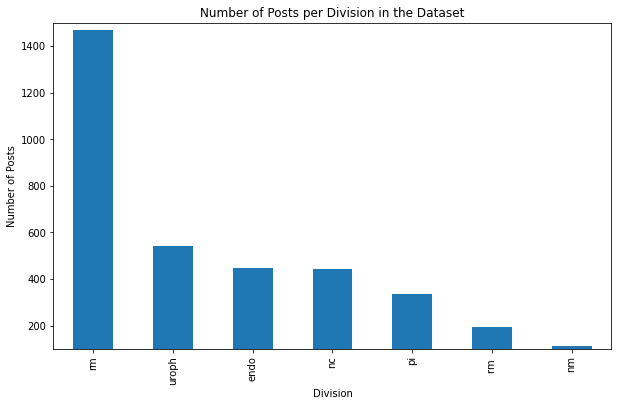

In [17]:
#df_numfile = pd.DataFrame(list(zip(os.listdir(basepath), file_numbers)), columns = ['Topic','Number of Documents'])
conto.plot(x = 'Division', y = 'Number of Posts', kind='bar', figsize=(10, 6), ylim = (100,1500), legend = None)
plt.xlabel('Division')
plt.ylabel('Number of Posts')
plt.title('Number of Posts per Division in the Dataset')

plt.show()

>By looking at the plot we can confirm that the classes are well-balanced.

>As we can see in the following chunk, the data is clearly still not ready 'for consumption':

In [18]:
data1 = df.copy()
data1.head()

,division,tezt
0,endo,Join us on July 1 @ 5 pm CET for another EMEA ...
1,endo,Join us on July 1 at 5 pm CET for another EMEA...
2,endo,Coming on Wednesday 6/24 @ 6 pm CET: the lates...
3,endo,Coming on Wednesday 24 June at 6 pm CET: the l...
4,endo,EXALT™ Model D Single-use Duodenoscope was fea...


In [19]:
# data1['Index']=range(0,len(data1))
# data1=data1.set_index('Index',drop=True)

>We then check if there are rows with missing values:

In [20]:
data1.isnull().sum()

division      0
tezt        182
dtype: int64

In [21]:
data1=data1.dropna()

In [22]:
# controllare se ci sono celle vuote o contenenti solo spazi bianchi
celle_vuote = data1.isna().any()
celle_blanks = (data1.applymap(str) == ' ').any()

# visualizzare le colonne contenenti celle vuote o contenenti solo spazi bianchi
print(celle_vuote[celle_vuote == True].index.tolist())
print(celle_blanks[celle_blanks == True].index.tolist())

[]
[]


>There are none, so we can go on. Next up, we check if we have rows filled only with whitespaces:

>Again, there are none. The main issue to solve now is the presence of lines in which the category of the text is written. For instance, you can see this in the first text, under lines 'Xref:...' and 'Newsgroups:...':

In [23]:
print(data1['tezt'][0]) #rimuovere hashtag?

Join us on July 1 @ 5 pm CET for another EMEA #Endoscopy webcast. Prof. Costamagna will present the first experiences with EXALT™ Model D Duodenoscope. Limited spaces; register now: https://t.co/u6F222OE7e #BSCEDUCARE


>After analyzing a little bit our texts, we came up with a list of lines that could contain the name of the topic to remove, other than some things that were out of our scope, like html tags, emails or numbers. We then lowered the case of all the words in the text, to not make distinctions between the same words but with different starting case. We did all of this defining a function and applying it to our texts: 

>As you can see below now the texts are clearly less readable by humans, but more readable by the machines, since we removed what could have interfered with the analysis:

>We then decided not to remove stopwords, at least for the moment, since the sentences would lose sense, so it would become harder for the machines to understand the context. We then check again, after the dataset cleaning, if there are rows made only by whitespaces:

>Again, there are no blanks, so we can pass to the next section.

## 1.2. **Exploratory Data Analysis**

### 1.2.1. **Topic Modeling**

We start our exploratory data analysis with 2 topic modeling methods:
* NMF
* LDA

We want to use these unsupervised clustering methods to see which 'natural groups of items' (topics) they find and compare them with the actual categories that we are looking for, to see which ones are found even with unsupervised techniques and which ones aren't naturally found

##### 1.2.1.1. **NMF**

##### Theoretical Explanation

Before describing the *NMF* method we have to introduce the *TF-IDF Vectorizer*, thanks to which we can apply this method. What it does, is creating a document term matrix from our texts. It then fills the matrix by calculating *term frequency-inverse document frequency* value for each word (from here, *TF-IDF*). Let's now describe both components:
* **Term Frequency - TF - tf(t,d)**: it is the raw count of a term in a document, that is, the number of times that term *t* occurs in document *d*. The problem of using just this, is that it emphasizes documents which happen to use very common words (like 'the' or 'and'), without giving enough weights to more meaningful terms 
* **Inverse Document Frequency - IDF**: to solve the problems of using the TF alone, we incorporate an inverse document frequency factor, which diminishes the weight of terms that occur very frequently in the document set, and increases the weight of terms that occur rarely. From a mathematical point of view, it is the logarithmically scaled inverse function of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):
\begin{align}
  IDF(W)=\log (\frac{M+1}{k})
  \end{align}

Summing up, *TF-IDF* is:
\begin{align}
  tfidf(t,d,D)=tf(t,d)\cdot idf(t,D)
  \end{align}
Where *idf* is:
\begin{align}
  idf(t,D)=\log \frac{N}{|\{d\in D:t \in d\}|}
  \end{align}


*Non-negative Matrix Factorization* simultaneously performs dimensionality reduction and clustering. We can use it in conjunction with the *TF-IDF* just introduced above to model topics across documents. How does it work?
* Given a non-negative matrix *A*, find a k-dimension approximation in terms of non-negative factors *W* and *H*
* Approximate each object (that is, columns of *A*) by a linear combination of *k* reduced dimensions or 'basis vectors' in *W*
* Each basis vector can be interpreted as a cluster. The memberships of objects in these clusters is encoded by *H*
  * Inputs: 
    * Non-negative data matrix (*A*)
    * Number of basis vectors (*k*)
    * Initial values for factors *W* and *H* (for example, random matrices)
  * Objective function: some measure of reconstruction error between *A* and the approximation *WH*
  \begin{align}
  \frac{1}{2}||A-WH||_F^2=\sum_{i=1}^n\sum_{j=1}^m(A_{ij}-(WH)_{ij})^2
  \end{align}
  * Expectation-Maximization (*E-M*) optimisation to refine *W* and *H* in order to minimise the objective function. Common approach is to iterate between two multiplicative update rules until convergence
    1. Update H
    \begin{align}
  H_{cj}\leftarrow H_{cj}\frac{(WA)_{cj}}{(WWH)_{cj}}
  \end{align}
    2. Update W
    \begin{align}
  W_{ic}\leftarrow W_{ic}\frac{(AH)_{ic}}{(WHH)_{ic}}
  \end{align}

How does it work?
* Construct a vector space model for documents (after stopword filtering), resulting in a term-document matrix *A*
* Apply *TF-IDF* term weight normalisation to *A*
* Normalize *TF-IDF* vectors to unit length
* Initialise factors on *A*
* Apply *Projected Gradient* method for *NMF* to *A*

At the end of the process we have:
* Basis vectors: the topics (clusters) in the data
* Coefficient matrix: the membership weights for documents relative to each topic (cluster)

##### Implementation

>First of all, since here we don't need the whole sequence of words because we only need to know the most representative ones for each category, we can remove the stop words:

In [51]:
df_explo=data1.copy()
def filter_stop_words(train_sentences, stop_words):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        train_sentences[i] = ' '.join(new_sent)
    return train_sentences
stop_words = set(stopwords.words("english"))
train_sentences=df_explo['text'].values
train_sentences = filter_stop_words(train_sentences, stop_words)
df_explo['text']=train_sentences

>We can then start with the NMF approach, so firstly we import the vectorizer. The frequency that we chose is the range between 0.07 and 0.95, which gives us the right amount of words to have a clear vision on the topics: 

In [56]:
tfidf = TfidfVectorizer(use_idf=True,max_df=0.95, min_df=0.07) 
dtm = tfidf.fit_transform(df_explo['text'])

>We have now a matrix of 19997 rows (the number of texts we are analyzing) and 209 columns (the relevant words found from the vectorizer). Now, we can apply the NMF model and see the top 15 words for each topic:

In [48]:
nmf_model = NMF(n_components=7,random_state=42) # 20 components since there are 20 topics 
nmf_model.fit(dtm)
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n') 

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


THE TOP 15 WORDS FOR TOPIC #0
['www', 'dr', 'com', 'bscemea', 'boston', 'update', 'register', 'prof', 'patient', 'patients', 'learn', 'epeeps', 'here', 'https', 'co']


THE TOP 15 WORDS FOR TOPIC #1
['boston', 'dr', 'twitter', 'bscemea', 'webinar', 'prof', 'register', 'epeeps', 'patient', 'patients', 'here', 'learn', 'https', 'bit', 'ly']


THE TOP 15 WORDS FOR TOPIC #2
['webinar', 'prof', 'ly', 'in', 'register', 'here', 'patients', 'learn', 'boston', 'patient', 'https', 'com', 'update', 'linkedin', 'www']


THE TOP 15 WORDS FOR TOPIC #3
['com', 'co', 'bscemea', 'boston', 'www', 'here', 'https', 'patients', 'patient', 'register', 'in', 'webinar', 'epeeps', 'prof', 'dr']


THE TOP 15 WORDS FOR TOPIC #4
['com', 'co', 'bscemea', 'in', 'patient', 'boston', 'learn', 'https', 'epeeps', 'here', 'prof', 'webinar', 'register', 'us', 'join']


THE TOP 15 WORDS FOR TOPIC #5
['dr', 'co', 'bscemea', 'here', 'register', 'patients', 'patient', 'join', 'www', 'epeeps', 'in', 'boston', 'https', 'com', 

>Since there are elements that are clearly not relevant in classifying topics, we need to remove other words other than the stopwords: 


>*   **Recurring words** like references or writes
>*   **Dates** like days ('mon','tue'...) or months ('apr')
>*   **Websites address** like 'com', 'net'...

>It is then surely useful to redo this analysis by adding to the stopwords these words:





In [50]:
no=['references','writes','email','sender','mail','article','reply','mon','tue','thu', 'fri', 'apr',
    'gmt','ans','net','com','wed','www', 'dr', 'com', 'bscemea', 'boston', 'update', 'register', 'prof', 'patient', 'patients', 'learn', 'epeeps', 'here', 'https', 'co',
    'linkedin', 'join', 'www', 'dr', 'com', 'bscemea', 'in', 'register', 'twitter', 'webinar', 'prof', 'epeeps', 'here', 'https', 'co'] 
for i in no:
  stop_words.add(i)
train_sentences = filter_stop_words(train_sentences, stop_words)
df_explo['text']=train_sentences
tfidf = TfidfVectorizer(use_idf=True,max_df=0.95, min_df=0.07) 
dtm = tfidf.fit_transform(df_explo['text'])
nmf_model = NMF(n_components=7,random_state=42)
nmf_model.fit(dtm)
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n') 

THE TOP 15 WORDS FOR TOPIC #0
['linkedin', 'join', 'us', 'www', 'dr', 'com', 'bscemea', 'in', 'twitter', 'register', 'prof', 'epeeps', 'here', 'https', 'co']


THE TOP 15 WORDS FOR TOPIC #1
['linkedin', 'join', 'us', 'www', 'dr', 'com', 'co', 'bscemea', 'prof', 'register', 'epeeps', 'here', 'https', 'bit', 'ly']


THE TOP 15 WORDS FOR TOPIC #2
['co', 'dr', 'prof', 'us', 'join', 'ly', 'register', 'epeeps', 'here', 'in', 'https', 'twitter', 'linkedin', 'www', 'com']


THE TOP 15 WORDS FOR TOPIC #3
['ly', 'linkedin', 'join', 'us', 'www', 'com', 'co', 'bscemea', 'here', 'https', 'in', 'register', 'epeeps', 'prof', 'dr']


THE TOP 15 WORDS FOR TOPIC #4
['register', 'prof', 'ly', 'linkedin', 'us', 'www', 'here', 'dr', 'com', 'co', 'epeeps', 'https', 'join', 'in', 'bscemea']


THE TOP 15 WORDS FOR TOPIC #5
['ly', 'linkedin', 'www', 'com', 'co', 'bscemea', 'dr', 'in', 'epeeps', 'https', 'here', 'prof', 'register', 'join', 'us']




/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


>We can now compare the topics found with this method with the actual categories.

In [ ]:
df_nmf = pd.DataFrame(data=df_explo,columns=['group','text'])
topic_results = nmf_model.transform(dtm)
df_nmf['NMF topic'] = topic_results.argmax(axis=1)

In [ ]:
dominant_topics = df_nmf['NMF topic']
categories = df_nmf['group']
pd.crosstab(dominant_topics, categories) 

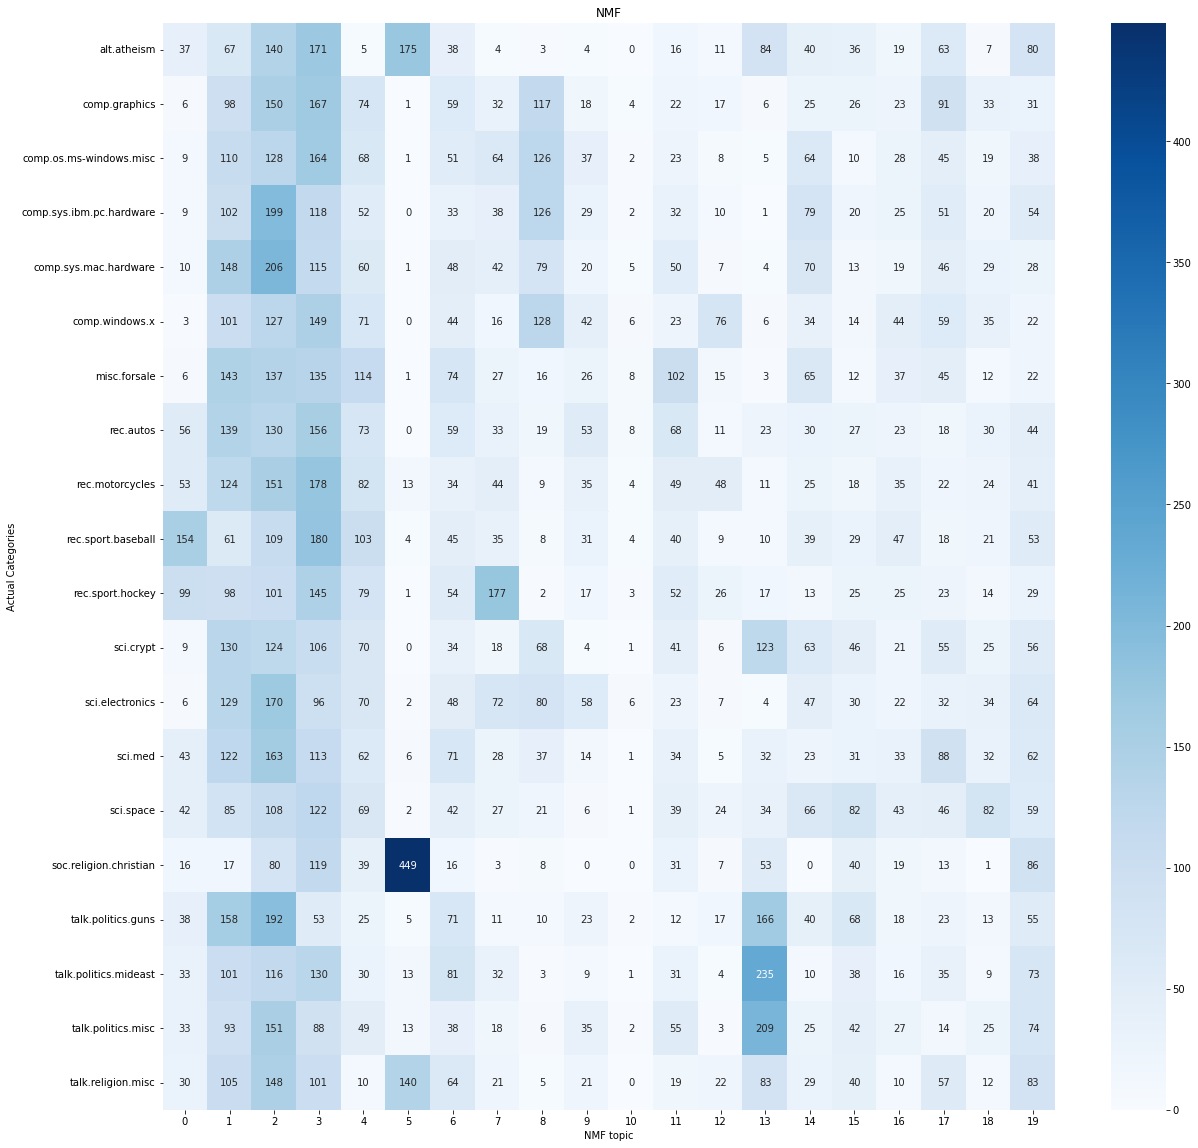

In [ ]:
plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(categories,dominant_topics),annot = True, fmt='', cmap='Blues')
plt.title('NMF')
plt.ylabel('Actual Categories')
plt.show()

>It's clear that the correspondency is not so big, but we can see from the table some of the topics found from the model are very similar to the ones we actually have. Other then 'soc.religion.christian', which matches well with the topic number 5, there are categories like 'talk.politics.mideast', 'rec.sport.hockey' or 'sec.sport.baseball' which match quite well with some other topics. This is quite explainable since as you can see again below these topics, the top words are quite specific:

>*   'soc.religion.christian'- 'reason', 'john', 'question'... all words related to Christianism (topic #5)
>*   'rec.sport.hockey' - 'uunet', 'usc', 'utexas'... university sports teams (topic #7)

>These should then theoretically be 'easier' topics to classify in the following steps than the others.

In [ ]:
nmfs=[0,5,7,13]
for index,topic in enumerate(nmf_model.components_):
  if index in nmfs:
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n') 

THE TOP 15 WORDS FOR TOPIC #0
['right', 'first', 'really', 'even', 'back', 'much', 'see', 'year', 'go', 'well', 'like', 'time', 'good', 'think', 'get']


THE TOP 15 WORDS FOR TOPIC #5
['come', 'reason', 'mean', 'john', 'know', 'see', 'question', 'true', 'must', 'may', 'us', 'say', 'believe', 'christian', 'god']


THE TOP 15 WORDS FOR TOPIC #7
['inc', 'zaphod', 'read', 'old', 'seen', 'first', 'last', 'group', 'well', 'best', 'university', 'uunet', 'usc', 'utexas', 'ca']


THE TOP 15 WORDS FOR TOPIC #13
['think', 'david', 'make', 'group', 'may', 'believe', 'fact', 'public', 'said', 'right', 'many', 'world', 'us', 'government', 'people']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### 1.2.1.2. **LDA**

##### Theoretical Explanation

The LDA method is based on the Dirichlet probability distribution, most used as the prior distribution of multinomial variables in hierarchical Bayesian models. Here, we have a multinomial classification, since we have to classify a text to the right category among 20 different ones. Here the assumptions are:
* Documents with similar topics use similar groups of words
* Latent topics can be found by searchin for groups of words that frequently occur together in documents across the corpus
* Documents are probability distributions over latent topics
* Topics themselves are probability distributions over words

In detail, what we will do is:
1. Go through each document and randomly assign each word in the document to one 
of the 20 topics, since we have texts from 20 categories and it would be useless to find another number of topics
2. For every document *d* and for each word *w*
  1. Proportion of words in document *d* that are currently assigned to topic *t* , that is 
  \begin{align}
  p(t|d)
  \end{align}
    * We try to capture how many words belong to the topic *t* for a given document *d*
    * If a lot of words from *d* belong to *t*, it is more probable that word *w* belongs to *t*
  2. Proportion of assignments to topic *t* over all documents that come from this word *w*, that is
  \begin{align}
  p(w|t)
  \end{align}
    * So how many documents are in topic *t* because of word *w*. 
    * As a topic is a mixture of words, if a word as high probability of being in a topic, all the documents having *w* will be more strongly associated with *t* as well
    * If *w* is not very probable to be in *t*, the documents which contain *w* will be having very low probability of being in *t* because the rest of the words in *d* will belong to some other topic and hence *d* will have a higher probability for that topic
        * That is, even if *w* gets added to *t*, it won't be bringing many documents to *t*
3. Reassign *w* to a new topic, where we choose topic *t* with probability
  \begin{align}
  p(\text{w with topic t}) =p(t|d)\cdotp(w|t)
  \end{align}
  which is essentially the probability that the topic *t* generated word *w*
    * After repeating the previous step many times, we eventually reach a roughly steady state where the assignments are acceptable.

As for mathematical definitions, we have:
* Inputs
  * A collection of *N* text documents:
  \begin{align}
  C=\left \{d_1,...,d_N\right \}
  \end{align}
  * Vocabulary set:
  \begin{align}
  V=\left \{w_1,...,w_M\right \}
  \end{align}
  * Number of topics:
  \begin{align}
  k
  \end{align}
* Outputs
  * *k* topics:
  \begin{align}
  \left \{\theta_1,...,\theta_k\right \}
  \end{align}
  * Coverage of topics in each $d_i$:
  \begin{align}
  \left \{\pi_1,...,\pi_N\right \}
  \end{align}
  * $\pi_{ij}$= probability of $d_i$ covering topic $\theta_j$
    * Collected in:
    \begin{align}
  \Lambda=(\left \{\theta_1,...,\theta_k\right \},\left \{\pi_{11},...,\pi_{1k}\right \},\left \{\pi_{N1},...,\pi_{Nk}\right \})
  \end{align}

With as constraints
\begin{align}
  \sum_{w\in V}p(w|\theta_i)=1
  \end{align}
   
\begin{align}
  \sum_{j=1}^k\pi_{ij}=1
  \end{align}

The mathematical model is as follows:
* Topic represented as word distribution
  * Multiple words: allow for describing a complicated topic
  * Weights on words: model subtle semantic variations of a topic
* Task of topic mining and analysis
 * Inputs: listed before
 * Outputs: $\Lambda$
 *Model data generation with a probabilistic model:
 \begin{align}
  p(\text{Data|Model,}\Lambda)
  \end{align}
  * Infer the most likely parameter values $\Lambda^*$ given a particulare data set:
  \begin{align}
  \Lambda^*=argmax_\Lambda p(\text{Data|Model,}\Lambda)
  \end{align}
  * Take $\Lambda^*$ as the 'knowledge' to be mined for the text mining problem
  * Adjust the design of the model to discover different knowledge

##### Implementation

>Like we did with the NMF approach, we vectorize our words, with the same frequency limits, but with a different vectorizer. In fact, while before we used the *TF-IDF*, here we use the *CountVectorizer*, which still creates a document term matrix, but fills it just with token counts:

In [57]:
cv = CountVectorizer(max_df=0.95, min_df=0.07)
dtm_lda = cv.fit_transform(df_explo['text'])

>As you can see above, the words are the same, since even if we work with defferent methods, we are still filtering by frequency of the words in the text. Following the same path as before, we can now apply the model and see the keywords for each topic:

In [58]:
LDA = LatentDirichletAllocation(n_components=20,random_state=42)
LDA.fit(dtm_lda) 
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['epeeps', 'learn', 'bscemea', 'us', 'webinar', 'ly', 'bit', 'co', 'join', 'dr', 'com', 'www', 'register', 'https', 'here']


THE TOP 15 WORDS FOR TOPIC #1
['prof', 'patients', 'epeeps', 'dr', 'webinar', 'us', 'ly', 'bit', 'co', 'join', 'bscemea', 'here', 'register', 'https', 'learn']


THE TOP 15 WORDS FOR TOPIC #2
['com', 'learn', 'ly', 'bit', 'prof', 'us', 'dr', 'join', 'co', 'bscemea', 'register', 'here', 'webinar', 'https', 'epeeps']


THE TOP 15 WORDS FOR TOPIC #3
['epeeps', 'patients', 'us', 'here', 'learn', 'webinar', 'prof', 'co', 'join', 'ly', 'bit', 'register', 'https', 'bscemea', 'dr']


THE TOP 15 WORDS FOR TOPIC #4
['us', 'join', 'dr', 'here', 'learn', 'patient', 'co', 'ly', 'bit', 'bscemea', 'register', 'webinar', 'www', 'https', 'patients']


THE TOP 15 WORDS FOR TOPIC #5
['boston', 'com', 'prof', 'here', 'register', 'learn', 'linkedin', 'ly', 'bit', 'co', 'www', 'patients', 'https', 'bscemea', 'patient']


THE TOP 15 WORDS FOR TOPIC #6
['h

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


>We can now see if the topics found by the model are the one we are looking for:

In [ ]:
df_lda = pd.DataFrame(data=df_explo,columns=['group','text'])
topic_results = LDA.transform(dtm_lda)
df_lda['LDA topic'] = topic_results.argmax(axis=1)

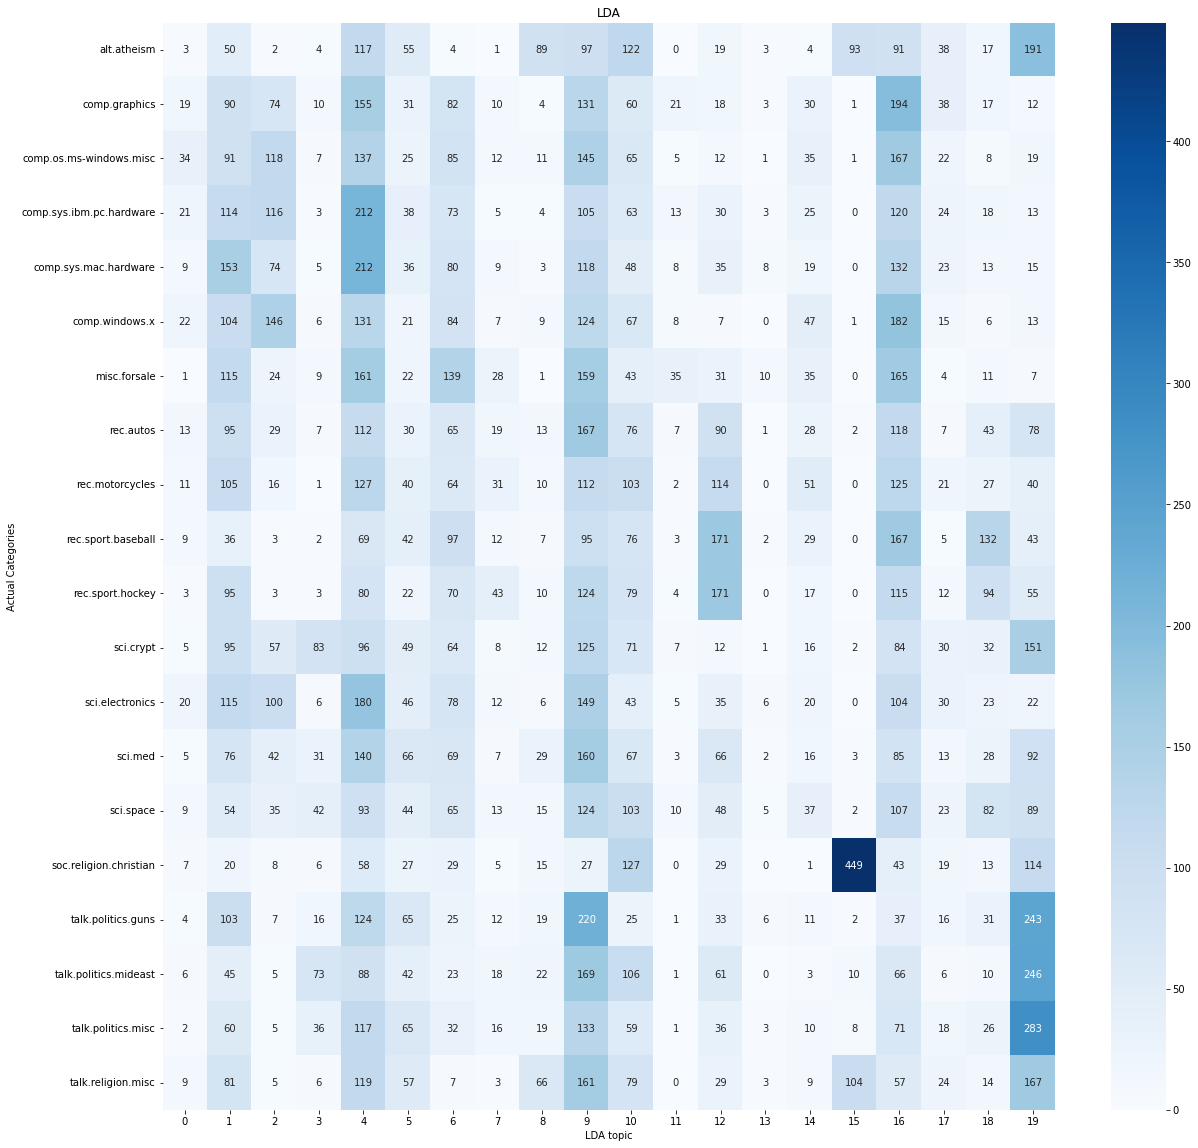

In [ ]:
dominant_topics = df_lda['LDA topic']
categories = df_lda['group']
plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(categories,dominant_topics),annot = True, fmt='', cmap='Blues')
plt.title('LDA')
plt.ylabel('Actual Categories')
plt.show()

>In the plot above, we can see a similar situation to the NMF approach. In fact, we still have only 1 good match ('soc.religion.christian', the same well-recognized category as before, with topic #15) and even less clear correspondences that before (for example, 'rec.sport.hockey' and 'rec.sport.baseball' now are not distinguished by different topics (both equally correspondent to topic #12), and the same with the macroarea of 'politics' (topic #19)). Here below a comparison between topics from NMF and LDA that can better explain the situation:

In [ ]:
ldas=[12,19]
nmfs=[7,13]
for index,topic in enumerate(LDA.components_):
  if index in ldas:
      print(f'THE TOP 15 WORDS FOR TOPIC #{index} (LDA)')
      print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
      print('\n')
for index,topic in enumerate(nmf_model.components_):
  if index in nmfs:
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} (NMF)')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n') 

THE TOP 15 WORDS FOR TOPIC #12 (LDA)
['get', 'well', 'got', 'years', 'year', 'new', 'like', 'last', 'said', 'go', 'two', 'back', 'first', 'time', 'one']


THE TOP 15 WORDS FOR TOPIC #19 (LDA)
['believe', 'want', 'government', 'well', 'even', 'say', 'right', 'said', 'like', 'us', 'know', 'one', 'think', 'would', 'people']


THE TOP 15 WORDS FOR TOPIC #7 (NMF)
['inc', 'zaphod', 'read', 'old', 'seen', 'first', 'last', 'group', 'well', 'best', 'university', 'uunet', 'usc', 'utexas', 'ca']


THE TOP 15 WORDS FOR TOPIC #13 (NMF)
['think', 'david', 'make', 'group', 'may', 'believe', 'fact', 'public', 'said', 'right', 'many', 'world', 'us', 'government', 'people']




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


>As you can see above, topic #12 of LDA contains more general words, while topic #13 of NMF (which was closer with 'talk.politics.mideast') contains more specific words such as 'us' or 'government'. This can be seen even clearer with the topics sports-related (#19 from LDA and #7 from NMF) since in the first one, there are again more general words, while in the second ones we can spot words like 'group', 'university' (along with names like 'utexas') which can better represent this category. This was quite foreseeable since as we said in the introduction of the model, here we use the *CountVectorizer* that analyses only the token counts, while the *TF-IDF* used by *NMF* calculates also the *term frequency-inverse document frequency*, which diminishes the weight of terms that occur very frequently in the document set, and increases the weight of terms that occur rarely, proposing then more 'interesting' words than *LDA*. Since the latter '*is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics, the weighting of TF-IDF is not necessary for this*' (Blei (*developer of LDA*), 2003), even though intuitely someone could have said to use *TF-IDF* to improve the results, this would be useless given the complete different mathematical nature behinf, so we stuck with the *CV*. 

### 1.2.2. **tSNE**

##### Theoretical Explanation


Before describing in detail the *tSNE*, we need to introduce the concept of **word embeddings**: 
* They are a type of word representation that allows words with similar meaning to have a similar representation.
* They are a *distributed* representation for text, a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector, and the vector values are learned in a way that resemmbles a neural network.  
* The distributed representation is learned based on the usage of words
  * Words that are used in similar ways result in having similar representations, naturally capturing their meaning. 

In particular, **word2vec**  is a two-layer neural network that processes text:
* Its input is a text corpus and its output is a set of vectors; the feature vectors for the words in that corpus
* The purpose of word2vec is to group the vectors of similar words together in the vector space
  * It detects similarities mathematically
* word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words
* Given enough data, usage and contexts, word2vec can make highly accurate guesses about a word's meaning based on past appearances
* Those guesses can be used to establish a word's association with other words
* Given that each word is represented by a vector, we can use *cosine similarity* to measure how similar word vectors are to each other

The problem with *word2vec* is that it learns embedding by relating target words to their context. Hence, it ignores some context words that appear more often than others. For *word2vec* in fact, a frequent co-occurence of words create more training examples, but carries no additional information. That's why here we chose to use **GloVe**
* *GloVe* stresses that the frequency of co-occurrences is vital information and should not be wasted as additional training examples
* *GloVe* looks at how often a word *j* appears in the context of a word *i* within all our corpus of texts
* To do so, let *X* be the word-word co-occurence matrix and $X_{ij}$ be the number of times word *j* appears in the context of word *i*
* *GloVe* will look at the ratio between those co-occurrence probabilities to extract the inner meaning of words
  \begin{align}
  P_{ij}=P(j|i)=\frac {X_{ij}}{\sum_{k\in context}X_{ik}}
  \end{align}
Which is, the co-occurrence probability of a word *j* to occur given a word *i* is the ratio of number of times word *j* occurs in the context of word *i* and the number of times any word appears in the context of word *i* 

Having said what embeddings are, we can now introduce *tSNE*. First of all, we can visualize embeddings by plotting them in a 2-dimensional space, which can show us how words are related. Most similar words should be plotted in groups while non related words will appear in a large distance. This requires a further dimension reduction technique to get the dimensions to 2 or 3. The most popular technique for reduction is itself an embedding method: **t-Distributed Stochastic Neighbor Embedding (tSNE)**.This is an unsupervised, randomize algorithm, used only for visualization: 
* It applies a non-linear dimensionality reduction technique where the focus is on keeping the very similar data points close together in lower-dimensional space.
* It preserves the local structure of the data using *Student t-distribution* to compute the similarity between two points in lower-dimensional space.
* *tSNE* uses a heavy-tailed *Student-t distribution* to compute the similarity between two points in the low-dimensional space rather than a *Gaussian* distribution, which helps to address the crowding and optimization problems.
* Outliers do not impact *tSNE*

##### Implementation

To give a clearer idea of the topics found by the unsupervised models above, it's useful to see graphically what were the clusters found, to see whether they are far from each other or, as expected by the missing correspondency between them and our actual categories, they are close, and hence difficult to classify and differentiate. To do this, we start applying the *tSNE* by first uploading the GloVe environment(dictionary, word2vec function, which saves the GloVe embeddings in the word2vec format, the model):

In [ ]:
root_folder='/content/drive/MyDrive/'
data_folder_name='NiLeMativ/'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name)) 

glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename)) 

train_path = DATA_PATH
test_path = DATA_PATH

TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

model_glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

>We then define the function that will allow us to display the words spatially:

In [ ]:
def display_closestwords_tsnescatterplot(model, dim, words):
    plt.style.use('ggplot')
    arr = np.empty((0,dim), dtype='f')
    word_labels = words
    
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)

    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(model, words): 
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    plt.style.use('ggplot')
    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show() 

>The words we are going to display are the ones obtained with the NMF approach, which we have seen before that can target more specific words, so it can be more useful for our analysis. Then, given that some words are not present in the GloVe dictionary, we remove them since we can't represent them spatially:

In [ ]:
topwords=[]
for index,topic in enumerate(nmf_model.components_):
    topwords.append([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
finaltop=[]
for j in range(len(topwords)):
    for i in range(len(topwords[j])):
        if topwords[j][i] not in ('utexas','gtefsd','udel','wupost'):
            finaltop.append(topwords[j][i])

>We are now ready to see the spatial representation:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


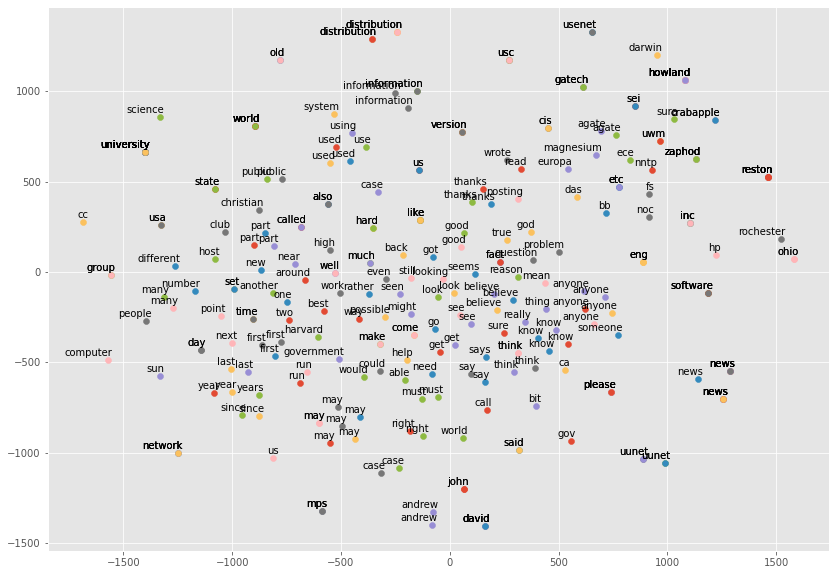

In [ ]:
tsne_plot(model_glove,finaltop)

>The first thing to notice is that many words (expecially more general ones like 'thanks','anyone' etc.), appear in more topics, and this is clearly something that makes the classification harder since they are not category-specific. Something that can be very useful, is to take each word just once, to see effectively how many groups formed by similar words there are, to have a little understanding on how many actual macroareas there are in our texts, looking just at the most representative words:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


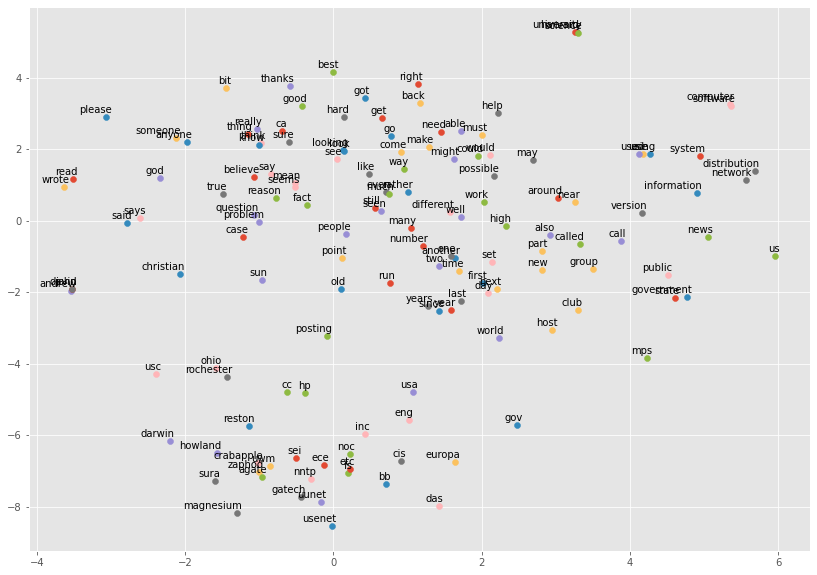

In [ ]:
def dopp(x):
  return list(dict.fromkeys(x))
uniq=dopp(finaltop)
tsne_plot(model_glove,uniq)

>As it's clear from the plot, the top words coming from the NMF model, seem to actually be divided in macroareas. We can in fact see:
>* In the bottom, a 'scientific' region (compatible with the 'sci....' macrotopic that we have). 
>* Just above the bottom, we can see terms related to universities, in particular american ones, terms that in the NMF analysis we saw matched with the sports are ('rec.sport....'). 
>* On the right, a 'religious' region, with terms like 'god', 'call', 'believe', 'john'...
>* In the center-left part, a small 'computer' area, compatible with 'comp....', with words like 'computer', 'software', 'network'...
>* In the upper-left area, a 'political' region (compatible with 'talk.politics....') with words such as 'government', 'state', 'world'...

>It's then clear that, by just looking at the top words, we can identify the macroareas of the categories that we are looking to classify, but it's then more difficult to arrive to the specific microcategory, since the most important words are shared by these regions.

# 2. **Machine Learning approach**

>To provide a benchmark to our forecoming models, we wanted to try a Machine Learning based approach. We started with splitting data in train and test: 

N.B.: We didn't consider a validation set since here we don't have to tune any hyperparameters so we don't actually need it.

In [ ]:
data1 = data1.rename(columns={'tezt': 'text'})

In [29]:
X = data1['text']
y = data1['division']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

>We then proceeded to build the pipeline for 2 of the 3 models we want to consider:


>*   **Multinomial Naïve Bayes**
>*   **Linear SVC**

>The pipeline is formed by a vectorizer, since the models accept only floats as input, and the model itself

In [30]:
# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
]) 

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()), 
])

## 2.1. **Multinomial Naïve Bayes**

> Bayesian classifiers are non-parametric classifiers based on bayesian rule, which assigns each observation to the most likely class given the value of the covariates.
> It is based on the assumption that the conditional probability of Y (probability of belonging to the different classes) given X is known

>Starting from the Multinomial Naïve Bayes model, we use the pipeline built above to train a model on our train set, we form a prediction set and we evaluate the performances on a confusion matrix, with the actual categories compared to the ones predicted, with also the help of a plot to have a better representation of the situation:

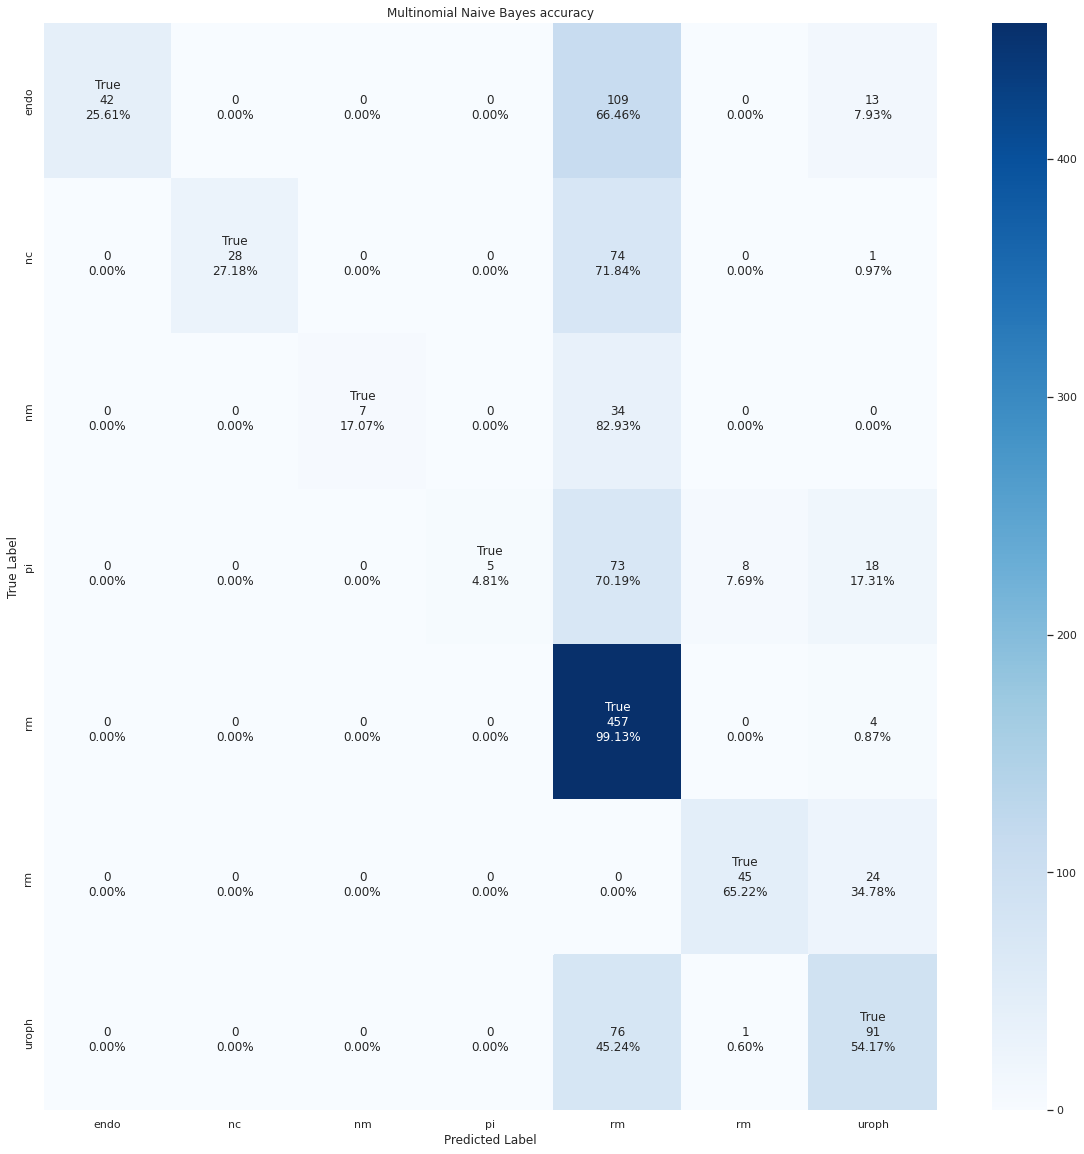

In [31]:
text_clf_nb.fit(X_train, y_train)
predictions = text_clf_nb.predict(X_test)
cf_matrix_MNB=metrics.confusion_matrix(y_test,predictions)
TF_labels = ['']*len(cf_matrix_MNB)*len(cf_matrix_MNB)
for i in range(len(cf_matrix_MNB)):
  TF_labels[i*7 + i] = 'True'
labels2 = ['endo','nc','nm','pi','rm','rm ','uroph']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_MNB.flatten()] 
cmn = cf_matrix_MNB.astype('float') / cf_matrix_MNB.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(7,7) 
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_MNB, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('Multinomial Naive Bayes accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

        endo       1.00      0.26      0.41       164
          nc       1.00      0.27      0.43       103
          nm       1.00      0.17      0.29        41
          pi       1.00      0.05      0.09       104
          rm       0.56      0.99      0.71       461
         rm        0.83      0.65      0.73        69
       uroph       0.60      0.54      0.57       168

    accuracy                           0.61      1110
   macro avg       0.86      0.42      0.46      1110
weighted avg       0.74      0.61      0.55      1110



In [33]:
#Save the metrics for the final comparison
precision_MNB_per_class = cf_matrix_MNB.diagonal()/cf_matrix_MNB.sum(axis=0)
recall_MNB_per_class = cf_matrix_MNB.diagonal()/cf_matrix_MNB.sum(axis=1)
f1_MNB_per_class = 2*(precision_MNB_per_class * recall_MNB_per_class)/(precision_MNB_per_class + recall_MNB_per_class)
acc_MNB = sum(cf_matrix_MNB.diagonal())/cf_matrix_MNB.sum()

> Plot of the F1 score for the single categories:

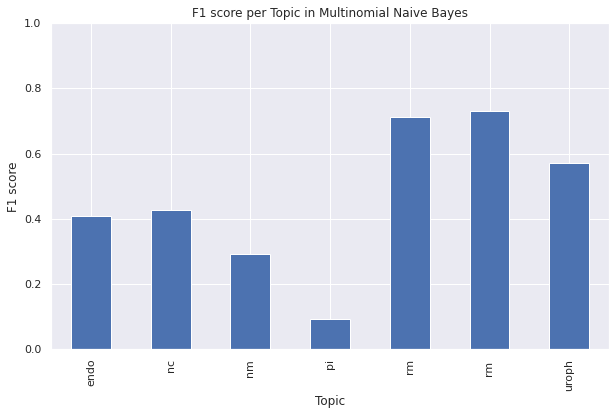

In [34]:
df_p_MNB = pd.DataFrame(list(zip(labels2, f1_MNB_per_class)), columns = ['Topic','f1 score'])
df_p_MNB.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1), legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in Multinomial Naive Bayes')

plt.show()

> We can group them in order to put similar topics together:

>As you can see from the plot of the confusion matrix (where the percentages refer to the recall metric) and the table above, the model has a remarkably high overall accuracy, 84%. As anticipated before, the topics that were identified from the unsupervised approaches, are the ones that have the highest F1 Score:

>*   'soc.religion.christian'- 94%
>*   'talk.politics.mideast' - 94%
>*   'rec.sport.hockey' - 94%

>The other categories all have scores around 80/90%, except for 2 'macroareas' of topics:
>* 'comp....' with: 
  * '.graphics' - 77%
  * '.sys.ibm.pc.hardware' - 76%
>* 'talk....' with:
  * '.politics.misc' - 72%
  * '.religion.misc' - 51%
  * 'alt.atheism' - 72%

>It's clear from the plot that this is due to the model predicting a topic in that macroarea (for example even 'sci.crypt' or 'sci.electronics', that even if they are not represented with the same prefix as the 'comp....' category, they still deal with computers, or the main problem tht shows up, the classication into 'talk.religion.misc' or 'alt.atheism', that again share the same region of interest, religion) but not exactly targeting the specific category. This is quite natural since in the same macroarea, the categories deal with the same topics to discuss, so they share many important words, and this is the main problem to solve in the forecoming architectures.


## 2.2. **Linear SVC**

> SVC (Support Vector Classifier) are an evolution of SVM (Support Vector Machines), a non-parametric approach for classification developed for binary tasks but that have been extended to cover cases of more than two classes. The idea is that it is possible to construct hyperplanes that separate observations according to their class label, assigning them depending on which side they belong to.
>
>Usually, data are not separable by a linear boundary, that's why we introduce a soft margin instead of a hard one, some observations are allowed to be in the incorrect side of the hyperplanes, which are chosen to correctly separate most of training observations.

>Using the same approach as with the Multinomial Naïve Bayes model, we proceed with analysing the accuracy.

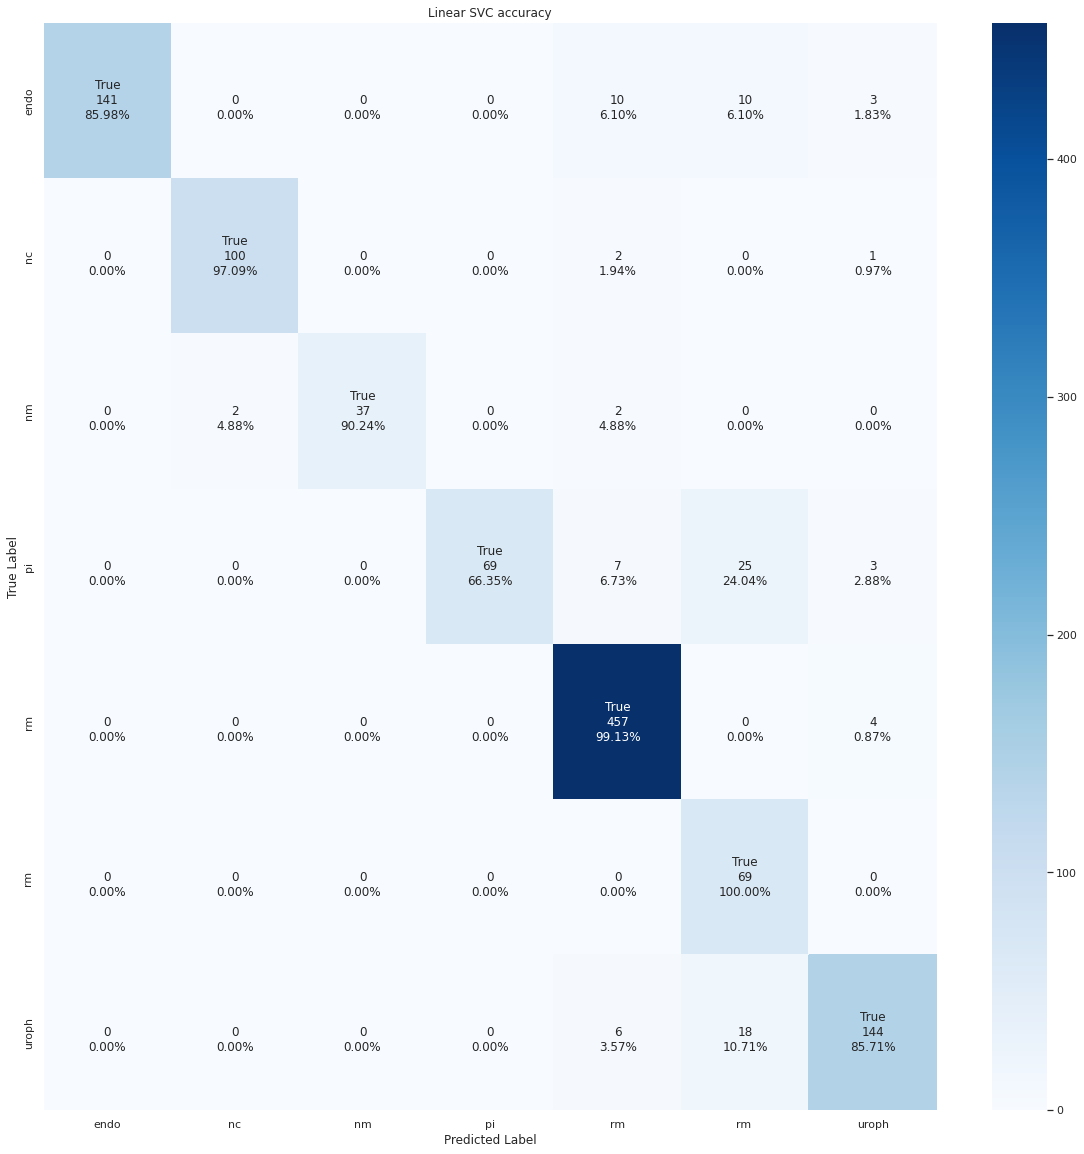

In [35]:
text_clf_lsvc.fit(X_train, y_train)
predictions = text_clf_lsvc.predict(X_test)
cf_matrix_SVC=metrics.confusion_matrix(y_test,predictions)
TF_labels = ['']*len(cf_matrix_SVC)*len(cf_matrix_SVC)
for i in range(len(cf_matrix_SVC)):
  TF_labels[i*7 + i] = 'True'


group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_SVC.flatten()] 
cmn = cf_matrix_SVC.astype('float') / cf_matrix_SVC.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)]
labels = np.asarray(labels).reshape(7,7)  
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_SVC, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('Linear SVC accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

        endo       1.00      0.86      0.92       164
          nc       0.98      0.97      0.98       103
          nm       1.00      0.90      0.95        41
          pi       1.00      0.66      0.80       104
          rm       0.94      0.99      0.97       461
         rm        0.57      1.00      0.72        69
       uroph       0.93      0.86      0.89       168

    accuracy                           0.92      1110
   macro avg       0.92      0.89      0.89      1110
weighted avg       0.94      0.92      0.92      1110



In [37]:
#Save the metrics for the final comparison
precision_SVC_per_class = cf_matrix_SVC.diagonal()/cf_matrix_SVC.sum(axis=0)
recall_SVC_per_class = cf_matrix_SVC.diagonal()/cf_matrix_SVC.sum(axis=1)
f1_SVC_per_class = 2*(precision_SVC_per_class * recall_SVC_per_class)/(precision_SVC_per_class + recall_SVC_per_class)
acc_SVC = sum(cf_matrix_SVC.diagonal())/cf_matrix_SVC.sum()
print(acc_SVC)

0.9162162162162162


>We show the plot with the F1 score per class:

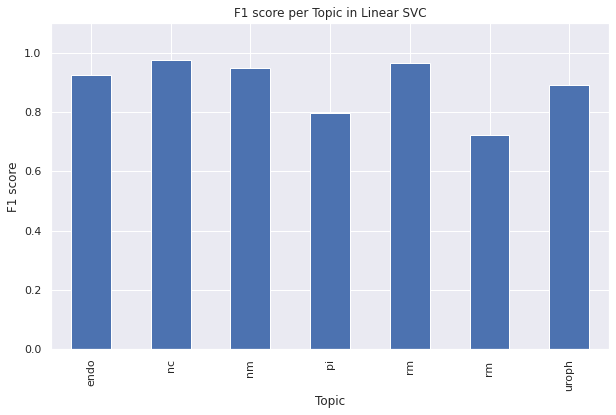

In [38]:
df_p_SVC = pd.DataFrame(list(zip(labels2, f1_SVC_per_class)), columns = ['Topic','f1 score'])
df_p_SVC.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in Linear SVC')

plt.show()

>As we could see with the first model, the overall accuracy is again high (89%), and we still have the same categories as before that perform worse than the others, even if with better values.

## 2.3. **Random Forest Classifier**

> Random Forest Classifiers derive from the Random Tree Classifiers, which are non-parametric classifiers that split the predictors space into rectangles, choosing iteratively the splits that explain the most the variable Y. Once the final regions have been created, for each region we predict Y (the label) as the most commonly occurring value of training observations.


>Following the same approach as before, we transform words to vectors, we apply the model and see its performance:

In [39]:
tfidf_rf=TfidfVectorizer()
Xtrain = tfidf_rf.fit_transform(X_train)
Ytrain = y_train

Xtest = tfidf_rf.transform(X_test)
Ytest = y_test

In [40]:
%%capture
clf = RandomForestClassifier(n_estimators=100)

clf.fit(Xtrain, Ytrain)

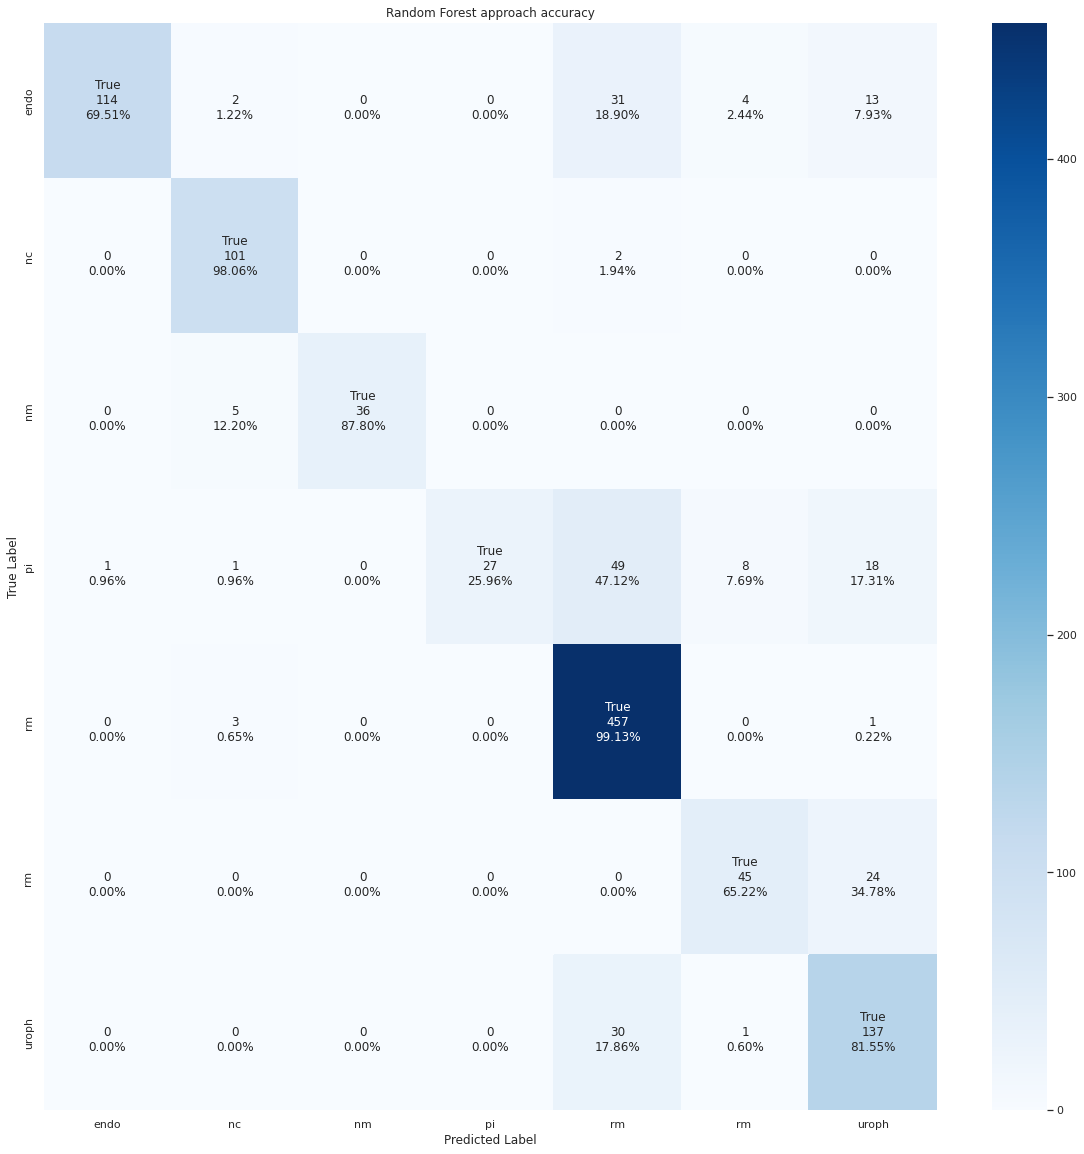

In [41]:
y_pred = clf.predict(Xtest)

cf_matrix_RF = metrics.confusion_matrix(y_test, y_pred)

TF_labels = ['']*len(cf_matrix_RF)*len(cf_matrix_RF)
for i in range(len(cf_matrix_RF)):
  TF_labels[i*7 + i] = 'True'

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_RF.flatten()] 
cmn = cf_matrix_RF.astype('float') / cf_matrix_RF.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()]  

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)]  
labels = np.asarray(labels).reshape(7,7)  
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_RF, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('Random Forest approach accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
print("train score:", round(clf.score(Xtrain, Ytrain),2),'\n')

print('test score:', metrics.classification_report(Ytest, y_pred,  digits=2))

train score: 1.0 

test score:               precision    recall  f1-score   support

        endo       0.99      0.70      0.82       164
          nc       0.90      0.98      0.94       103
          nm       1.00      0.88      0.94        41
          pi       1.00      0.26      0.41       104
          rm       0.80      0.99      0.89       461
         rm        0.78      0.65      0.71        69
       uroph       0.71      0.82      0.76       168

    accuracy                           0.83      1110
   macro avg       0.88      0.75      0.78      1110
weighted avg       0.85      0.83      0.81      1110



In [43]:
#Save the metrics for the final comparison
precision_RF_per_class = cf_matrix_RF.diagonal()/cf_matrix_RF.sum(axis=0)
recall_RF_per_class = cf_matrix_RF.diagonal()/cf_matrix_RF.sum(axis=1)
f1_RF_per_class = 2*(precision_RF_per_class * recall_RF_per_class)/(precision_RF_per_class + recall_RF_per_class)
acc_RF = sum(cf_matrix_RF.diagonal())/cf_matrix_RF.sum()
print(acc_RF)

0.8261261261261261


>Plot of the F1 score per class:

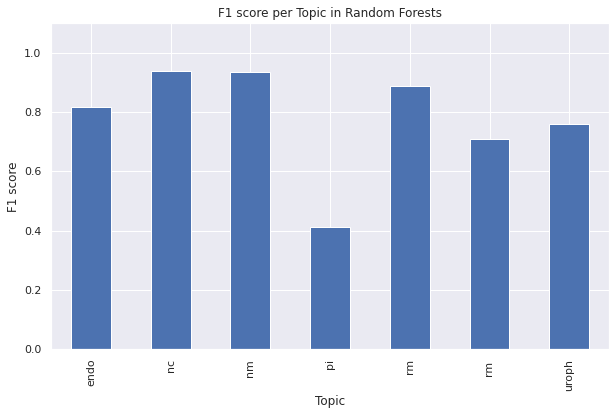

In [46]:
df_p_RF = pd.DataFrame(list(zip(labels2, f1_RF_per_class)), columns = ['Topic','f1 score'])
df_p_RF.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in Random Forests')

plt.show()

>With this approach we get the worst overall performance out of the 3 models (~78%, which is normal. since this model performs well mostly with binary classification) but we can still see the same trends as before, with some categories predicted well above the rest ('soc.religion.christian' - ~97%) and others well below ('talk.religion.misc' - ~50%).



# 3. **Neural Network approach**

Now, we are ready to implement the neural network and test its performance.

>We need a tokenizer to be fitted on the cleaned text, on which the sequences we'll be created and splitted in three subset:
1. Train set, used for the forward propagation of the networks;
2. Validation set, used to evaluate the performance of the model at every epoch;
3. Test set to check how our model is good in generalization.

In [47]:
df_mdl=data1.copy()

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_mdl['text'])

X_train, X_test, y_train, y_test = train_test_split(df_mdl['text'], df_mdl['division'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [49]:
print(f'The vocabulary size of our text data is: {len(tokenizer.word_index)}')

The vocabulary size of our text data is: 11873


In [50]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

Our texts are now tokenized and for each "observation" we have a corresponding sequence of token index in the vocabulary. This is just a first step: to feed a neural network we need all the vectors to have the same length, so we must use the keras function pad_sequences to reshape each of them in the same dimensions. The vector smaller than a specific maximum length will be filled with 0's entries.

How to choose the maximum length of the sequence?

There are no scientific methods to do this choice, but we can check the percentiles of the sequences length to have a clearer idea:

In [51]:
sequence_len = np.array([len(s) for s in train_sequences])
print([(str(p)+'%', round(np.percentile(sequence_len,p))) for p in range(75,101,5)])

[('75%', 43), ('80%', 45), ('85%', 47), ('90%', 52), ('95%', 66), ('100%', 178)]


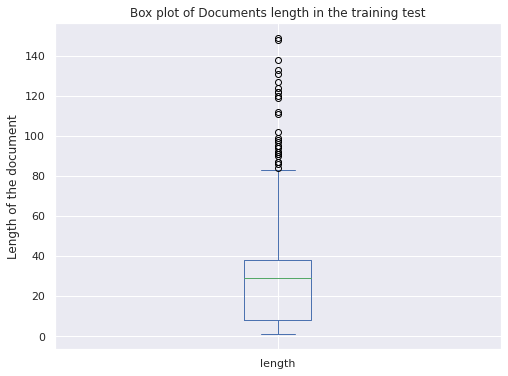

In [52]:
texts_len = []
texts = X_train.tolist()
for i in range(len(texts)):
  texts_len.append(len(texts[i].split()))
texts_len_df = pd.DataFrame(texts_len, columns = ['length'])
texts_len_df.plot(kind='box', figsize=(8, 6))
plt.title('Box plot of Documents length in the training test')
plt.ylabel('Length of the document')

plt.show()

There are some "extreme" data in the length of our documents. The box is very small in this plot, so let's try to plot it considering only the first 75% of the values:

In [53]:
less_323 = texts_len_df[texts_len_df["length"] < 43]

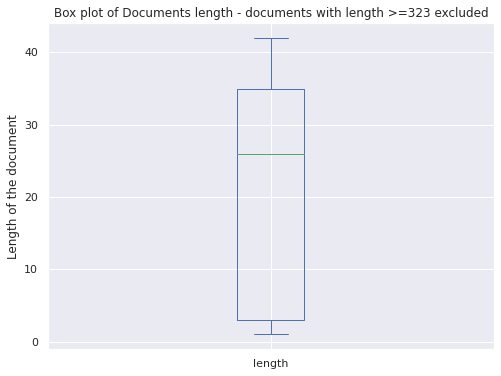

In [54]:
less_323.plot(kind='box', figsize=(8, 6))
plt.title('Box plot of Documents length - documents with length >=323 excluded')
plt.ylabel('Length of the document')

plt.show()

In [55]:
less_323 = less_323[less_323["length"] < 43]
print(f'The % of the value kept if we set padding length equal to 323 is: {round(less_323.shape[0]/len(texts),5)*100}%')

The % of the value kept if we set padding length equal to 323 is: 86.797%


After some attempt, we can state that using the padding maximum length equal to the 75° percentile of the lengths distribution lead us to good result in the trade-off between model performance and training/evaluation time.

In [56]:
max_len = 43

X_train = pad_sequences(train_sequences,maxlen=max_len, truncating='post')
X_val = pad_sequences(val_sequences,maxlen=max_len, truncating='post')
X_test = pad_sequences(test_sequences,maxlen=max_len, truncating='post')


We also need to transform our response in dummy variables to perform the neural network:

In [57]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values
y_val = pd.get_dummies(y_val).values

In [58]:
print(f'Train set dimensions{(X_train.shape,y_train.shape)}')
print(f'Validation set dimensions{(X_val.shape,y_val.shape)}')
print(f'Test set dimensions{(X_test.shape,y_test.shape)}')

Train set dimensions((2151, 43), (2151, 7))
Validation set dimensions((538, 43), (538, 7))
Test set dimensions((673, 43), (673, 7))


The above are the final dimensions of the three different sets needed for NN approach. As we can observe, the X's have as second dimension 322, which is the maximum length of padding.

In [ ]:
embedding_vector = {}
f = open('/content/drive/MyDrive/NiLeMativ/glove.6B.100d.txt')

for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:07, 55669.52it/s]


We used the same GloVe used in the ML approach, with 100 dimensions.

Then, we have a vocabulary which contains 99522 words (specific for our dataset), and we'll fill an embedding matrix with the co-occurences from glove dictionary.

Since we're using 100d glove, each word embedding vector will have length equal to 100, namely each of the 99522 word will have 100 co-occurences with other tokens 

In [ ]:
vocab_size=len(tokenizer.word_index)+1

embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 99522/99522 [00:00<00:00, 627187.88it/s]


We end-up with a matrix 99522x100 that will be used in LSTM.

The reason why we use Glove Embedding is that having a co-occurences matrix helps us in take advantage of the power of LSTM in sequence evaluation.

## 4.1 Neural network definition and training


Now that we have the GloVe matrix, we can use its values as weights in the input layer of our network, that will be fed with the vectorized sequences with size equal to 99523. 

In the network, we immediatly add a LSTM layer with 128 units followed by a Dropout, used to add noise, something which improves the generalization power of the model. Then we repeat the LSTM-Dropout sequence until we end with a linear layer with a Softmax activation function that gives as output a vector of 20 elements for each observation. Each element in this vector represents the probability of belonging to a specific category.

In [ ]:
model2m = Sequential()

model2m.add(Embedding(vocab_size,100,weights = [embedding_matrix],input_length=322,trainable = False))
model2m.add(LSTM(256))
model2m.add(Dropout(0.2))
model2m.add(Reshape((1,256),input_shape=(256,)))
model2m.add(LSTM(128))
model2m.add(Dropout(0.2))
model2m.add(Reshape((1,128),input_shape=(128,)))
model2m.add(LSTM(128))
model2m.add(Dense(20, activation='softmax'))

model2m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 322, 100)          9952300   
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0

In [ ]:
model2m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2, verbose=1, mode="auto", restore_best_weights=False)

model2m.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[callback],validation_data = (X_val, y_val))

Epoch 1/20
400/400 [==============================] - 18s 24ms/step - loss: 2.7850 - accuracy: 0.0954 - val_loss: 2.3146 - val_accuracy: 0.1706
Epoch 2/20
400/400 [==============================] - 9s 22ms/step - loss: 2.0791 - accuracy: 0.2361 - val_loss: 1.7604 - val_accuracy: 0.3256
Epoch 3/20
400/400 [==============================] - 8s 21ms/step - loss: 1.5201 - accuracy: 0.4356 - val_loss: 1.2735 - val_accuracy: 0.5191
Epoch 4/20
400/400 [==============================] - 8s 21ms/step - loss: 1.1595 - accuracy: 0.5728 - val_loss: 1.0377 - val_accuracy: 0.6147
Epoch 5/20
400/400 [==============================] - 8s 21ms/step - loss: 0.9264 - accuracy: 0.6602 - val_loss: 0.9038 - val_accuracy: 0.6800
Epoch 6/20
400/400 [==============================] - 9s 22ms/step - loss: 0.7833 - accuracy: 0.7142 - val_loss: 0.8147 - val_accuracy: 0.7228
Epoch 7/20
400/400 [==============================] - 8s 21ms/step - loss: 0.6812 - accuracy: 0.7560 - val_loss: 0.7683 - val_accuracy: 0.747

In [ ]:
predictions = model2m.predict(X_test)
predictions_classes = np.argmax(predictions,axis=1)

y_test_classes = np.argmax(y_test, axis=1)
score,acc = model2m.evaluate(X_test, y_test, verbose = 2, batch_size = 64)

print("Test accuracy: %.3f" % (acc)) 

125/125 [==============================] - 2s 9ms/step
63/63 - 2s - loss: 0.7103 - accuracy: 0.7768 - 2s/epoch - 27ms/step
Test accuracy: 0.777


### Model results

As we have seen, the model achieves an accuracy on training data which is close to 85% and a validation accuracy close to 78%.

Of course, we expected to get a test accuracy close to the validation one, and it is actually about 78%.

The general result is not very high-performing, we can explore a confusion matrix divided by class to better understand where the problems are:

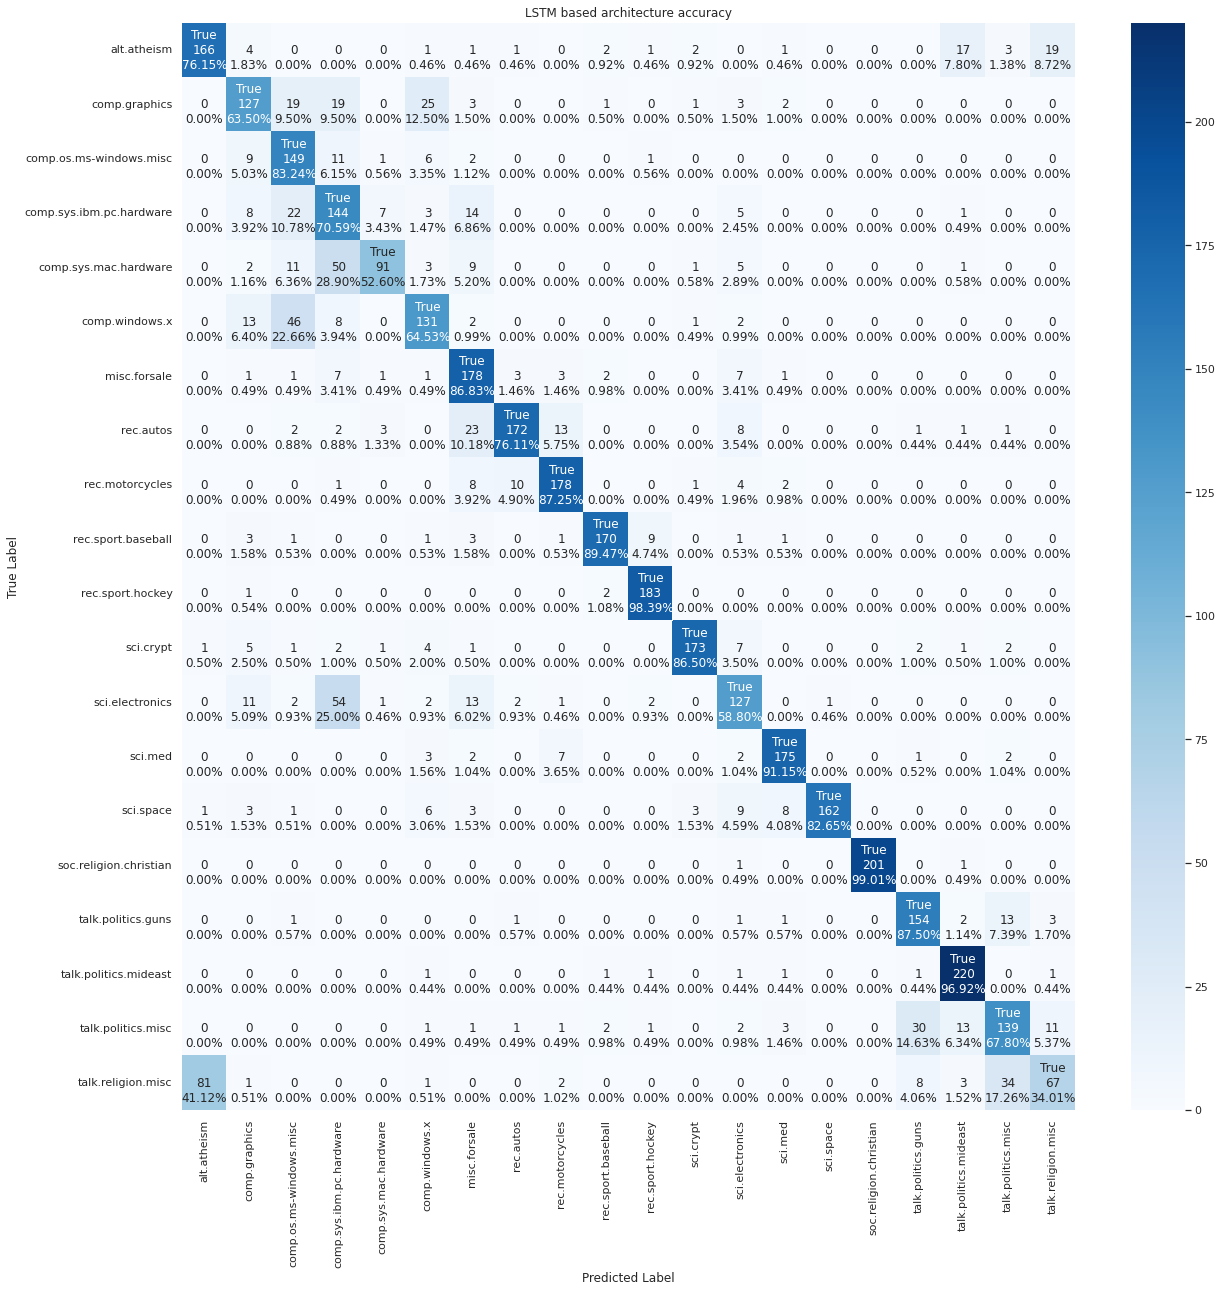

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix_LSTM = confusion_matrix(y_test_classes, predictions_classes)
TF_labels = ['']*len(cf_matrix_LSTM)*len(cf_matrix_LSTM)
for i in range(len(cf_matrix_LSTM)):
  TF_labels[i*20 + i] = 'True'

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_LSTM.flatten()] 
cmn = cf_matrix_LSTM.astype('float') / cf_matrix_LSTM.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 



labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(20,20) 
plt.figure(figsize = (20,20))
sns.set(font_scale=1)


sns.heatmap(cf_matrix_LSTM, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('LSTM based architecture accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Print a classification report
from sklearn import metrics
print(metrics.classification_report(y_test_classes, predictions_classes,target_names=labels2)) 

                          precision    recall  f1-score   support

             alt.atheism       0.67      0.76      0.71       218
           comp.graphics       0.68      0.64      0.65       200
 comp.os.ms-windows.misc       0.58      0.83      0.69       179
comp.sys.ibm.pc.hardware       0.48      0.71      0.57       204
   comp.sys.mac.hardware       0.87      0.53      0.65       173
          comp.windows.x       0.69      0.65      0.67       203
            misc.forsale       0.68      0.87      0.76       205
               rec.autos       0.91      0.76      0.83       226
         rec.motorcycles       0.86      0.87      0.87       204
      rec.sport.baseball       0.94      0.89      0.92       190
        rec.sport.hockey       0.92      0.98      0.95       186
               sci.crypt       0.95      0.86      0.91       200
         sci.electronics       0.69      0.59      0.63       216
                 sci.med       0.90      0.91      0.90       192
         

In [ ]:
#Save the metrics for the final comparison
precision_LSTM_per_class = cf_matrix_LSTM.diagonal()/cf_matrix_LSTM.sum(axis=0)
recall_LSTM_per_class = cf_matrix_LSTM.diagonal()/cf_matrix_LSTM.sum(axis=1)
f1_LSTM_per_class = 2*(precision_LSTM_per_class * recall_LSTM_per_class)/(precision_LSTM_per_class + recall_LSTM_per_class)
acc_LSTM = sum(cf_matrix_LSTM.diagonal())/cf_matrix_LSTM.sum()

> Plot of the test F1 score per class:

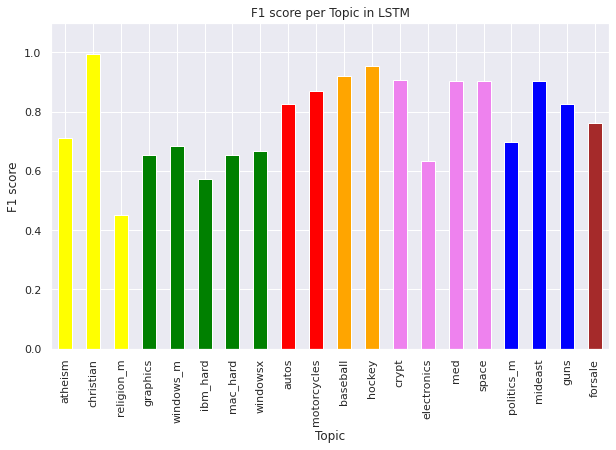

In [ ]:
df_p_LSTM = pd.DataFrame(list(zip(labels_red, f1_LSTM_per_class)), columns = ['Topic','f1 score'])
df_p_LSTM= df_p_LSTM.reindex([0, 15, 19, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 18, 17, 16,6])
df_p_LSTM.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), color = cols_clusters, legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in LSTM')

plt.show()

As we can observe from the report and the classification matrix, there is an obvious problem related to two categories: Religion and Atheism. This was foreseeable, in general we can expect that words used in talking about the argument 'religion' are very equal to ones used in 'atheism' argument. 

## 4.3 Bi-LSTM architecture definition and training

We decided also to try the bidirectional LSTM in our network, to check if it can improve the performance. The difference with the basic LSTM is that it considers the sequence not only in one direction (forward) but also backward: in fact, instead of taking into account the next word in a sentence, the Bi-LSTM can take into account also the word before.

In [ ]:
modelbi = Sequential()

modelbi.add(Embedding(vocab_size,100,weights = [embedding_matrix],input_length=322))
modelbi.add(Bidirectional(LSTM(128)))
modelbi.add(Dropout(0.5))
modelbi.add(Reshape((1,256),input_shape=(256,)))
modelbi.add(Bidirectional(LSTM(256)))
modelbi.add(Dropout(0.5))
modelbi.add(Reshape((1,512),input_shape=(512,)))
modelbi.add(Bidirectional(LSTM(256)))
modelbi.add(Dropout(0.5))
modelbi.add(Reshape((1,512),input_shape=(512,)))
modelbi.add(Bidirectional(LSTM(128)))
modelbi.add(Dense(64))
modelbi.add(Dense(20, activation='softmax'))

modelbi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 322, 100)          9952300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [ ]:
modelbi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2, verbose=1, mode="auto", restore_best_weights=False)
modelbi.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[callback],validation_data = (X_val, y_val))

Epoch 1/20
400/400 [==============================] - 30s 49ms/step - loss: 2.6221 - accuracy: 0.1246 - val_loss: 2.2010 - val_accuracy: 0.1703
Epoch 2/20
400/400 [==============================] - 17s 42ms/step - loss: 1.9607 - accuracy: 0.2521 - val_loss: 1.7067 - val_accuracy: 0.3634
Epoch 3/20
400/400 [==============================] - 17s 43ms/step - loss: 1.4897 - accuracy: 0.4090 - val_loss: 1.3709 - val_accuracy: 0.4644
Epoch 4/20
400/400 [==============================] - 21s 53ms/step - loss: 1.0718 - accuracy: 0.5477 - val_loss: 1.1497 - val_accuracy: 0.5591
Epoch 5/20
400/400 [==============================] - 22s 54ms/step - loss: 0.7957 - accuracy: 0.6601 - val_loss: 1.0774 - val_accuracy: 0.6266
Epoch 6/20
400/400 [==============================] - 17s 42ms/step - loss: 0.7874 - accuracy: 0.6856 - val_loss: 1.1006 - val_accuracy: 0.6309
Epoch 7/20
400/400 [==============================] - 17s 42ms/step - loss: 0.5916 - accuracy: 0.7513 - val_loss: 0.9975 - val_accuracy:

In [ ]:
predictions = modelbi.predict(X_test)
predictions_classes = np.argmax(predictions,axis=1)

y_test_classes = np.argmax(y_test, axis=1)
score,acc = modelbi.evaluate(X_test, y_test, verbose = 2, batch_size = 16)

print("Test accuracy: %.3f" % (acc))

125/125 [==============================] - 8s 21ms/step
250/250 - 9s - loss: 0.9811 - accuracy: 0.7837 - 9s/epoch - 38ms/step
Test accuracy: 0.784


### Bi-directional LSTM architecture results:

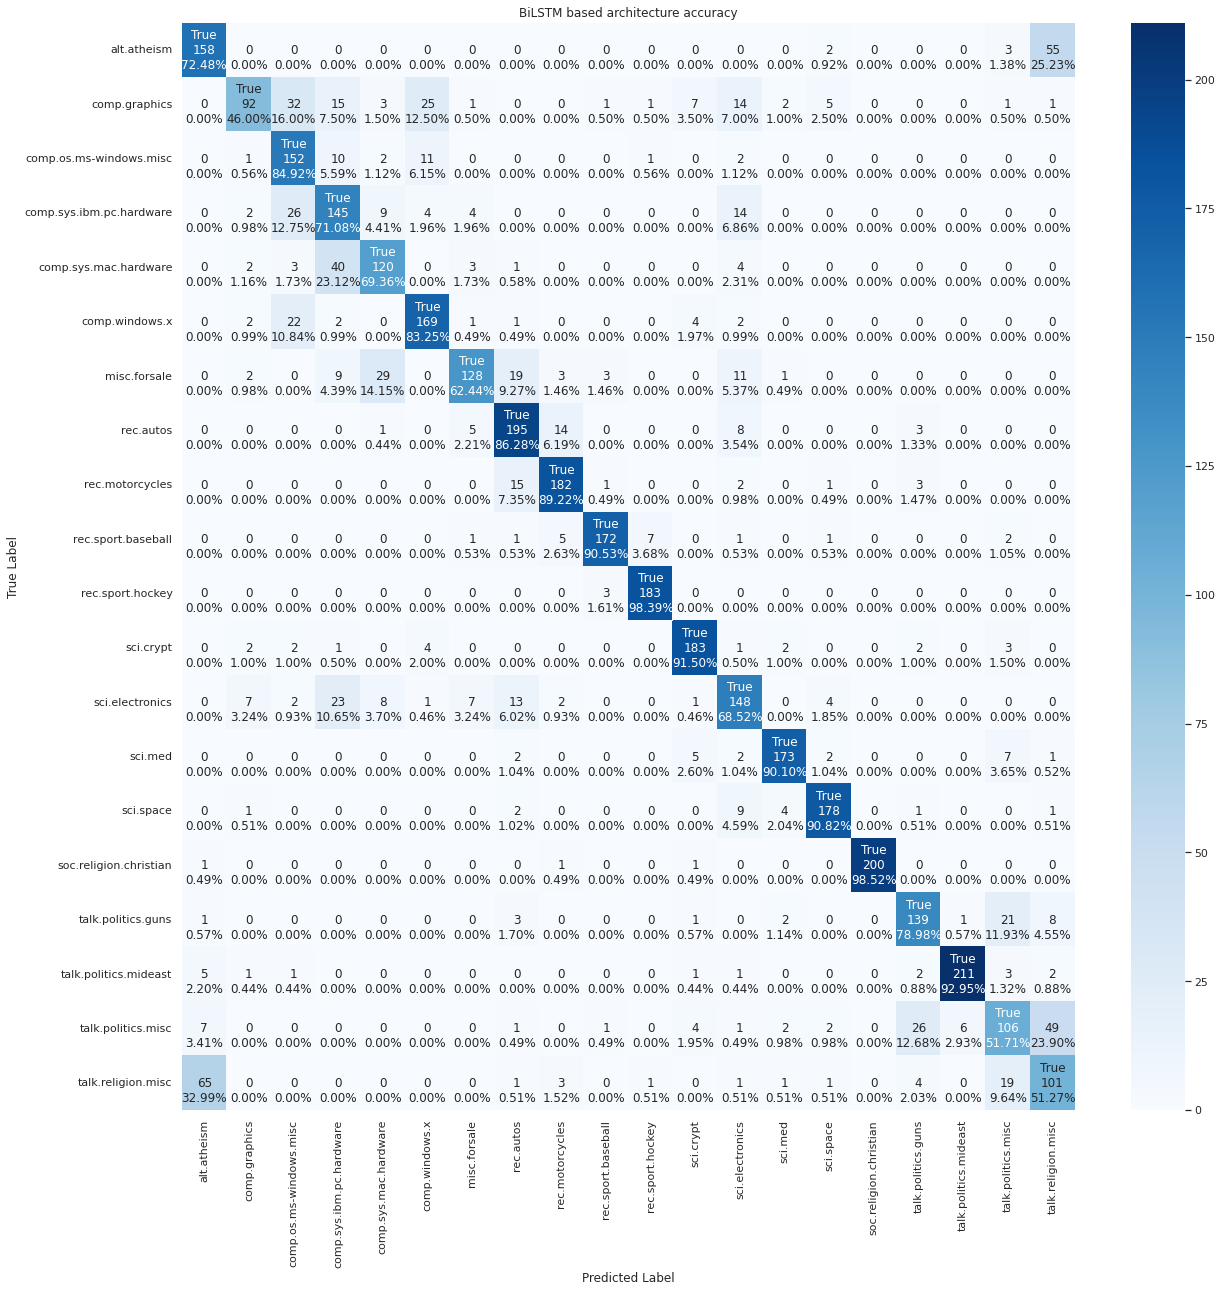

In [ ]:
cf_matrix_biLSTM = confusion_matrix(y_test_classes, predictions_classes)

TF_labels = ['']*len(cf_matrix_biLSTM)*len(cf_matrix_biLSTM)
for i in range(len(cf_matrix_biLSTM)):
  TF_labels[i*20 + i] = 'True'

labels2 = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x',
'misc.forsale','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med','sci.space',
'soc.religion.christian','talk.politics.guns','talk.politics.mideast','talk.politics.misc','talk.religion.misc']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_biLSTM.flatten()] 
cmn = cf_matrix_biLSTM.astype('float') / cf_matrix_biLSTM.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(20,20)
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_biLSTM, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2)
plt.title('BiLSTM based architecture accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Print a classification report
from sklearn import metrics
print(metrics.classification_report(y_test_classes, predictions_classes)) #labels?

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       218
           1       0.82      0.46      0.59       200
           2       0.63      0.85      0.73       179
           3       0.59      0.71      0.65       204
           4       0.70      0.69      0.70       173
           5       0.79      0.83      0.81       203
           6       0.85      0.62      0.72       205
           7       0.77      0.86      0.81       226
           8       0.87      0.89      0.88       204
           9       0.95      0.91      0.93       190
          10       0.95      0.98      0.97       186
          11       0.88      0.92      0.90       200
          12       0.67      0.69      0.68       216
          13       0.93      0.90      0.91       192
          14       0.91      0.91      0.91       196
          15       1.00      0.99      0.99       203
          16       0.77      0.79      0.78       176
          17       0.97    

In [ ]:
#Save the metrics for the final comparison
precision_biLSTM_per_class = cf_matrix_biLSTM.diagonal()/cf_matrix_biLSTM.sum(axis=0)
recall_biLSTM_per_class = cf_matrix_biLSTM.diagonal()/cf_matrix_biLSTM.sum(axis=1)
f1_biLSTM_per_class = 2*(precision_biLSTM_per_class * recall_biLSTM_per_class)/(precision_biLSTM_per_class + recall_biLSTM_per_class)
acc_biLSTM = sum(cf_matrix_biLSTM.diagonal())/cf_matrix_biLSTM.sum()
print(acc_biLSTM)

0.78375


>Plot of the test F1 score per class:

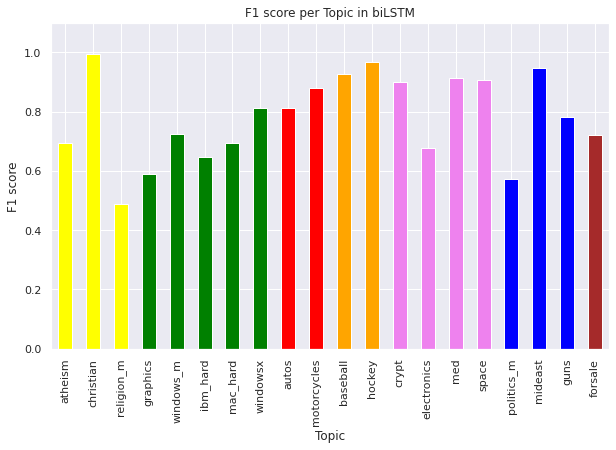

In [ ]:
df_p_biLSTM = pd.DataFrame(list(zip(labels_red, f1_biLSTM_per_class)), columns = ['Topic','f1 score'])
df_p_biLSTM= df_p_biLSTM.reindex([0, 15, 19, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 18, 17, 16,6])
df_p_biLSTM.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), color = cols_clusters, legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in biLSTM')

plt.show()

The Bi-directional LSTM does not improve our analysis, after different attempts we can conclude that this is the best that we can obtain with a LSTM and BiLSTM based architectures.

# 4. **Word Clouds**

>To better inspect the problem in the classification of some of the categories, we decided through some *word clouds* to see the most representative words of these 'difficult' categories, to see if the may have in common many important words, a fact that could justify the not-so-high accuracy. Since we are going to look purely at the frequencies, we modify the function we used at the beginning to remove everything that could disturb us, so another recurring structures like 'From:...', 'Subject:...' and so on, since we are not going to use vectorizers like *TF-IDF* or *CountVectorizer* that can filter words by their frequences:

In [ ]:
def clean_all(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)
    text = re.sub(r'(Supersedes:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Approved:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Organization:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Distribution:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Followup-To:\s+[^\n]+\n)', '', text) # in this row there is the category written
    text = re.sub(r'(Expires:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Date:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Message-ID:\s+[^\n]+\n)', '', text) 
    text = re.sub(r'(Keywords:\s+[^\n]+\n)', '', text) # in this row there is the category written
    text = re.sub(r'(Summary:\s+[^\n]+\n)', '', text) # in this row there is the category written
    text = re.sub(r'(Newsgroup:\s+[^\n]+\n)', '', text) # this is literally the category
    text = re.sub(r'(Path:\s+[^\n]+\n)', '', text) 
    text = re.sub(r'(Xref:\s+[^\n]+\n)', '', text) # in this row there is the category written
    text = re.sub(r'(Newsgroups:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)

    return text

df_cl=data1.copy()
df_cl['text']=df_cl['text'].apply(clean_all)

>We then query through all texts to extract the single categories we are interested in, then we join all texts per category in a single one, since we need to know the most important words not in a single text but throughout all categories:

In [ ]:
ath=df_cl.query("group=='alt.atheism'")
polm=df_cl.query("group=='talk.politics.misc'")
rel=df_cl.query("group=='talk.religion.misc'")
gun=df_cl.query("group=='talk.politics.guns'")

gra=df_cl.query("group=='comp.graphics'")
ibm=df_cl.query("group=='comp.sys.ibm.pc.hardware'")
win=df_cl.query("group=='comp.os.ms-windows.misc'")
mac=df_cl.query("group=='comp.sys.mac.hardware'")
winx=df_cl.query("group=='comp.windows.x'")


athj=' '.join(text for text in ath.text)
polmj=' '.join(text for text in polm.text)
relj=' '.join(text for text in rel.text)
gunj=' '.join(text for text in gun.text)

graj=' '.join(text for text in gra.text)
ibmj=' '.join(text for text in ibm.text)
winj=' '.join(text for text in win.text)
macj=' '.join(text for text in mac.text)
winxj=' '.join(text for text in winx.text)

>We now define the stopwords, taking them from the 'wordcloud' library, and adding some words that give no importance to the analysis, that is recurring words like 'references', 'sender'... and words coming from the removal of puntuaction like 'don' (coming from "don't"). For the same exact reason, we remove all the single letters from the alphabet that again don't bring any importance, and are also very frequent expecially in the "comp.os.ms-windows.misc", given the presence of code in the texts: 

In [ ]:
stopwc = set(STOPWORDS)

stp=['don','references','lines','nntp','posting','host','one',
're','sender','ax','say','know','even','thing','see']
for i in stp:
  stopwc.add(i)

alph=list(ascii_lowercase) #alphabet
for i in alph:
  stopwc.add(i)

>We are now ready to plot. First of all, we instantiate a word cloud object, then we divide the analysis in 2 parts:
1. We inspect the 'sociological' categories that get confused with each other, in particular:
  * 'alt.atheism'
  * 'talk.politics.misc'
  * 'talk.religion.misc'
  * 'talk.politics.guns'
2. We take a look at the 'tech' categories that again get confused with each other:
  * 'comp.graphics'
  * 'comp.sys.ibm.pc.hardware'
  * 'comp.os.ms-windows.misc'
  * 'comp.sys.mac.hardware'
  * 'comp.windows.x'


In [ ]:
text_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwc
)

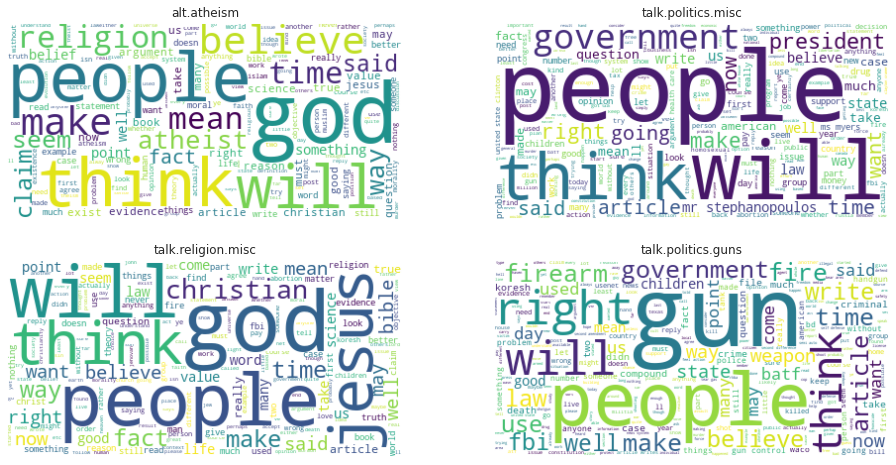

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(16,8))
text_wc.generate(athj)
axs[0,0].imshow(text_wc, interpolation='bilinear') 
axs[0,0].axis('off')
axs[0,0].set_title("alt.atheism")

text_wc.generate(relj)
axs[1,0].imshow(text_wc, interpolation='bilinear') 
axs[1,0].axis('off')
axs[1,0].set_title("talk.religion.misc")

text_wc.generate(polmj)
axs[0,1].imshow(text_wc, interpolation='bilinear') 
axs[0,1].axis('off')
axs[0,1].set_title("talk.politics.misc")

text_wc.generate(gunj)
axs[1,1].imshow(text_wc, interpolation='bilinear') 
axs[1,1].axis('off')
axs[1,1].set_title("talk.politics.guns")
plt.show()

>It's now clear from the word clouds why with these categories our model perform worse than with others. We can see that in all 4 categories, one of the most representative words is 'people', which is quite straightforward since again we are talking about a 'sociological' area of interest, since both in religion and politics people are the key point. 
* Looking at the left side, we can inspect the most difficult categorization that arised from our models, and we can see all the words in common between them:
  * God
  * Will (to intend also as one's willingness)
  * Think
  * Christian
    * Given these similiraties, it's now more evident that the categorization here is the hardest since many representative words are in common, hence it's difficult for the models to choose one category or the other
* Looking at the right side, we can see the other difficulty of our models, that is distinguishing between the general category of politics talk, and the specific one about guns. Here the problems were of course smaller than the contrast just seen in the left side of the plot, and we can surely see why, since beside 'people' and 'will' (that here may assume more of a verb sense rather than 'philosophical') we can see:
  * Think
  * Government
  * Right
    * Hence, words that of course have to deal with both the categories. The difference is that this time, the category 'talk.politics.guns' has the most representantive word, '*gun*' that doesn't appear in the more general category '....misc', hence this makes the categorization easier than in the case above, where this role was played by the word 'jesus', which instead was less representative, since it came after common words like 'god' or 'christian'.

Before passing to the analysis of the 'tech' topics, we decided to remove 'will' from the clouds, since now we are not talking about something 'sociological' so it's highly likely that here that term has the role of a verb. Once done this, we passed to plotting:

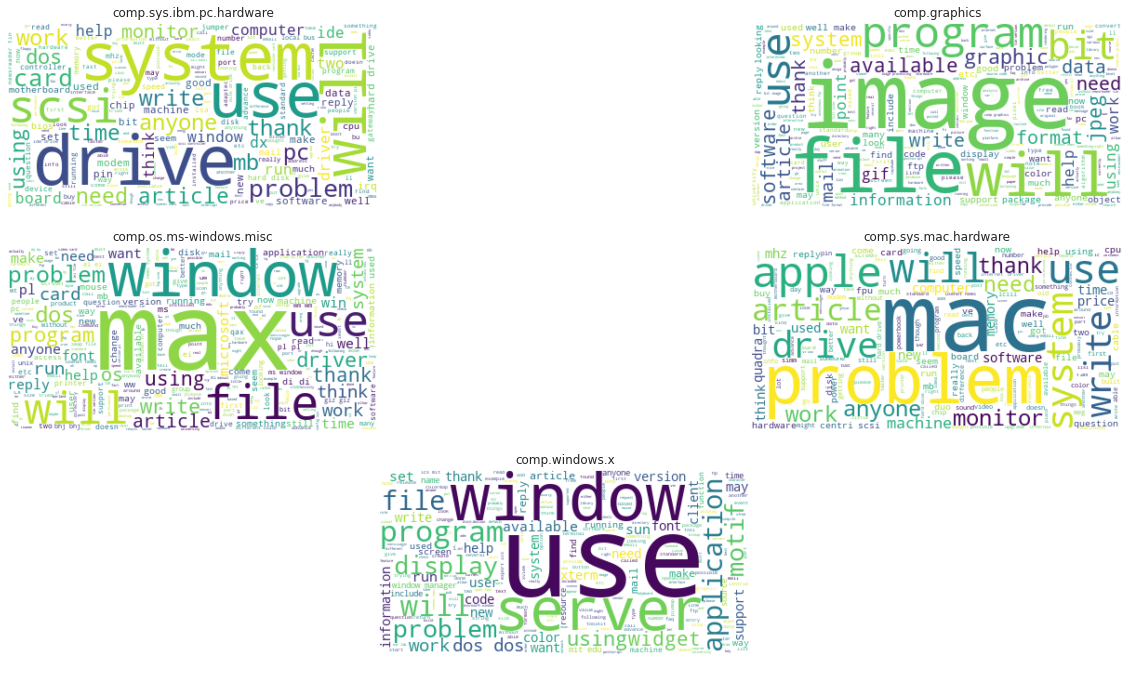

In [ ]:
stopwc2 = set(STOPWORDS)
stp2=['don','references','lines','nntp','posting','host','one',
're','sender','ax','say','know','even','thing','see','will']
for i in stp2:
  stopwc2.add(i)

for i in alph: #alphabet
  stopwc2.add(i)
  
text_wc2 = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwc2
) 

fig, axs = plt.subplots(3, 3,figsize=(20,12))


text_wc.generate(ibmj)
axs[0,0].imshow(text_wc, interpolation='bilinear') 
axs[0,0].axis('off')
axs[0,0].set_title("comp.sys.ibm.pc.hardware")

text_wc.generate(winj)
axs[1,0].imshow(text_wc, interpolation='bilinear') 
axs[1,0].axis('off')
axs[1,0].set_title("comp.os.ms-windows.misc")

text_wc.generate(winxj)
axs[2,1].imshow(text_wc, interpolation='bilinear') 
axs[2,1].axis('off')
axs[2,1].set_title("comp.windows.x")

text_wc.generate(graj)
axs[0,2].imshow(text_wc, interpolation='bilinear') 
axs[0,2].axis('off')
axs[0,2].set_title("comp.graphics")

text_wc.generate(macj)
axs[1,2].imshow(text_wc, interpolation='bilinear') 
axs[1,2].axis('off')
axs[1,2].set_title("comp.sys.mac.hardware")

axs[0,1].axis('off')
axs[1,1].axis('off')
axs[2,0].axis('off')
axs[2,2].axis('off')

fig.subplots_adjust(wspace=0.001, hspace=0.09)

plt.show()

In this "macro-area" we can see word-clouds that are similar not in the most used words, while instead in the secondary (smaller) elements of the clouds.
Examples are:


*   system
*   drive
*   work
*   monitor
*   application
*   problem
*   file
*   etc.


This is reasonable: mac users will use "mac" or "apple" more than a windows user, but the argument of the discussions will be similar with small technical differentiation, and this will create the ambiguity in the classification algorithm execution.

# 5. **Transformer Based approach**

##### Theoretical Explanation

The Transformers architecture, introduced by the paper *Attention is all you need* by Vawsani et al. in 2017, has the same aim as LSTM, which is transforming one sequence into another (seq2seq), with the help of an Encoder and a Decoder.

Traditionally, the Encoder block passes its final states to the decoder, but this generates an information bottleneck, as long sequences can be a challenge if a bad summary is done (long-range dependency problem of RNN/LSTMs).

On the other hand, thanks to the mechanism of Attention, the Transformers encoder passes all the hidden states to the decoder, which looks at them and determines a score for each hidden state, removing those with a lower score.

Like LSTM, Transformers transform one sequence into another with the help of an Encoder and a Decoder, but it differs because it does not imply any Recurrent Networks like GRU or LSTM.

The Encoder is made of a stack of layers, each containing a self-attention and a feed forward layer. The Decoder has another attention layer that helps it focus on relevant parts of the input.

Self-attention/intra-attention is an attention mechanism that relates different positions of a sequence to get a better encoding at each position, acting similarly to the memory of the hidden state in a RNN. Each module uses Multi-Headed Attention (explained later), inputs and outputs are embedded in a n-dimensional space. Since we don't have any recurrent network, there is a positional encoding which gives every word a relative position, added to the embedded representation.

The models we used are Encoder only models, which map an input sequence into a numerical representation (vector) well suited for classification or entity recognition. The representation for a token relies on both left and right context-directional attention.

Each encoder layer receives a sequence of embeddings. The input size is equal to the output size, the main goal is to update the embeddings according to the context. The attention mechanism assigns different weights to each element (token embedding) in the sequence. With self-attention weights are computed for all the hidden states of the encoder.

Self attention updates raw token embeddings into contextualized embeddings to capture information from the whole sequence.

With scaled-dot-product attention the model projects each token embedding into three vectors: Q, K, V, and computes attention scores with a similarity function dot product, then computes the attention weight: the scores are scaled to normalize their variance and then with a softmax function to ensure their values sum to 1. The model then updates the token embeddings with the new attention weight.

With multi-headed attention the Attention module repeats its computations multiple times in parallel. It splits its Q, K and V parameters N-ways and passes each split independently through a separate head. All the calculations are then combined together to produce a final Attention score, giving the Transformer greater power to encode multiple relationships.

The feed-forward layer is a simple 2 layer fully connected neural network, it processes each embedding independently with a GELU activation function.

Positional Embeddings add position dependent patterns of value arranged into a vector to boost the token embeddings. The attention heads and the feed forward layers can learn to incorporate the position.

Finally, in Encoder-only model, such as the ones we used for the dask, to build a classifier we have to add the classification head.

The base architecture of transformers, explained before, is shown in the picture below, taken from the paper *Attention is all you need*:

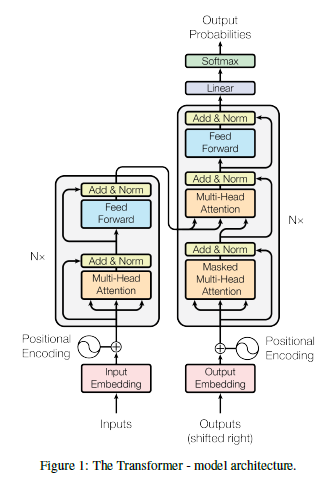

##### Implementation

>For the task, we decided to use two different transformers models, BERT base and RoBERTa, in order to compare the performance of the two.
>
>The implementation was done using the Pytorch version of the huggingface trainer, which seemed handier to use.

## 5.1. **BERT base**

> BERT stands for Bidirectional Encoder Representations from Transformers. It's designed to pre-train deep bidirectional representations by conditioning on left and right context.
>
>The pre-trained BERT model can be fine-tuned with one additional output layer to create models for a wide range of NLP tasks.
>
>BERT base has 12 layers, 768 hidden states and 12 attention heads. It takes a sequence of words as input which flow up the stack. Each layer applies self attention and results are passed through a feed-forward network.
>
>The first input token is supplied with a special [CLS] token, which stands for Classification. 
>
>Each position outputs a vector of size 768, for classification we focus only on the first position, that we passed the special [CLS] token to.
>
>We initialize all parameters from the pre-trained model and fine-tune them in the fine-tuning stages.


In [ ]:
df_TF = df_mdl
df_TF['class_int'] = pd.Categorical(df['group']).codes
df_TF.head()

,group,text,class_int
Index,,,
0,comp.sys.mac.hardware,path cantaloupe srv cs cmu edu das news harva...,4
1,comp.sys.mac.hardware,path cantaloupe srv cs cmu edu crabapple srv ...,4
2,comp.sys.mac.hardware,path cantaloupe srv cs cmu edu crabapple srv ...,4
3,comp.sys.mac.hardware,path cantaloupe srv cs cmu edu crabapple srv ...,4
4,comp.sys.mac.hardware,path cantaloupe srv cs cmu edu crabapple srv ...,4


>As written before, the first transformer model we want to try is Bert base. Before training the model, we have to choose the parameter for padding and truncation, we set it as the same used for LSTM which captures 75% of the text: 322.

>There are many outliers which make visualization hard. Let's try to visualize only the lenght of documents with length less than 1000.

In [ ]:
model_name = "bert-base-uncased" 
max_length = 322

>We load the tokenizer with the Autotokenizer function, specifying that the model we want to use it fore is BERT base, the output tells us some details about the model architecture, such as the activation function (GELU), the hidden size (768), the number of attention heads(12) and the number of hidden layers (12):

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

>Since we need to train the model and tune the hyperparameters during training, we need a training, validation and test set (the last one will be used for a final evaluation of the performance).
>
>We perform a 60-20-20 split into training, validation and test set:

In [ ]:
random.seed(10)

target_names_compl = df_TF['group'].tolist()
target_names = np.unique(df_TF['group'])
labels = df_TF['class_int'].tolist()
texts = df_TF['text'].tolist()
train_texts, validtest_texts, train_labels, validtest_labels, training_names, validtest_names = train_test_split(texts, labels, target_names_compl, test_size = 0.4)
valid_texts, test_texts, valid_labels, test_labels, valid_names, test_names = train_test_split(validtest_texts, validtest_labels, validtest_names, test_size = 0.5)

>Now we can, using the tokenizer we loaded before, tokenize the three datasets, truncate at max_length and pad with 0 when the length is lower than max_length, this is needed as our data must be passed all with the same fixed length:

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

>Before training, having decided to use the PyTorch training from huggingface, we need to convert our tokenized data into a torch Dataset:

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)

>We need to use the GPU during the fine-tuning step, as it's computationally expensive, therefore we load the model and pass to CUDA. We select the BERT model for sequence classification as it's the one we need to predict the text labels:

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

>We create a function for computing evaluation metrics, as the metrics will be computed on the whole dataset, we expect precision, recall and F1 score to be equal to the accuracy (we tried it and it's true). Because of that, our compute_metrics function will only compute the accuracy:

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    #prec = precision_score(labels, preds, average = 'micro') #not useful in multiclass classification on the whole dataset
    #rec = recall_score(labels, preds, average = 'micro') #not useful in multiclass classification on the whole dataset
    #f1 = f1_score(labels, preds, average = 'micro') #not useful in multiclass classification on the whole dataset
    
    return {
      'accuracy': acc,
      #'precision': prec, #not useful in multiclass classification on the whole dataset
      #'recall': rec, #not useful in multiclass classification on the whole dataset
      #'f1 score': f1 #not useful in multiclass classification on the whole dataset
    }

>We set the train arguments and tune the model's hyperparameters on our data (the model is pre-trained so we don't have to do that). The objective now is to find optimal values for the model hyperparameters in order to minimize the empirical loss.
>
>The default trainer uses an Adam-based optimization algorithm.
>
>We select the following training arguments:
>
>
>*   Number of training epochs: 3, we could use a higher value but this chunk took around 35 minutes to run and we didn't want to increase the computation time any further, besides, the accuracy obtained on the last iteration was satisfactory enough
*   Training batch size: 10, this means that, having around 12000 documents in the training set, each epoch will take 1200 iterations
*   Validation batch size: 20, this means that, having around 4000 documents in the training set, each epoch will take 200 iterations. We chose a higher value than the training batch size not to slow down computation much, because we compute validation metrics every 200 training iterations
*   Warmup_steps = 500, this means that in the first steps the learning rate will be very low, to increase later, in order to prevent early overfitting
*   Weight decay = 0.1, it adds a L2 penalty to shrink weights in order to avoid overfitting by penalizing highly valued coefficients
*   fp16 = True, half precision  is a binary floating-point computer number format that occupies 16 bits instead of 32. It is intended for storage of floating-point values in applications where higher precision is not essential, in particular image processing and neural networks. This makes computation faster
* logging_steps=200, the number of training steps after which we log weights
* save_steps=200, the number of training steps after which we save weights
* evaluation_strategy="steps", we evaluate on the validation steps depending on the steps and not on the epochs
* seed = 10, to ensure reproducibility

In [ ]:
random.seed(10)
os.environ["WANDB_DISABLED"] = "true"
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,               # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    fp16 = True,                     # to make computation faster
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=200,               # log weights each logging_steps
    save_steps=200,                  # save weights each save_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    seed = 10                        #to ensure reproducibility
)

trainer = Trainer(
    model=model_init(),                  # the instantiated Transformers model to be trained, we have to call a function in order to obtain reproducibility as explained in https://discuss.huggingface.co/t/fixing-the-random-seed-in-the-trainer-does-not-produce-the-same-results-across-runs/3442/4
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
# train the model

trainer.train()

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
200,2.743000,2.049696,0.518380
400,1.487500,0.964783,0.740185
600,0.940100,0.779802,0.761190
800,0.772400,0.714243,0.785446
1000,0.687200,0.599794,0.816954
1200,0.614000,0.517124,0.841710
1400,0.443900,0.587381,0.835209
1600,0.457200,0.525784,0.848462
1800,0.405300,0.487445,0.853463
2000,0.365200,0.523628,0.855714


***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
****

TrainOutput(global_step=3600, training_loss=0.6044346608055963, metrics={'train_runtime': 1690.1505, 'train_samples_per_second': 21.296, 'train_steps_per_second': 2.13, 'total_flos': 5956968482964576.0, 'train_loss': 0.6044346608055963, 'epoch': 3.0})

>The accuracy reached on the validation set at the end of the third epoch is around 88%, a high value but now we need to see the performance on the test set, even if we expect it to be close to the one obtained by the best model on the validation set.

In [ ]:
%%capture
# saving the fine tuned model & tokenizer
model = trainer.model
model_path = "20newsgroups-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(target_names)).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_path)

Configuration saved in 20newsgroups-bert-base-uncased/config.json
Model weights saved in 20newsgroups-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in 20newsgroups-bert-base-uncased/tokenizer_config.json
Special tokens file saved in 20newsgroups-bert-base-uncased/special_tokens_map.json
loading configuration file 20newsgroups-bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "20newsgroups-bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",

>We evaluate of the model performance on the test set, by printing a confusion matrix and a classification report:

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]

In [ ]:
pred_names = []
for i in range(len(test_names)):
  pred_names.append(get_prediction(test_texts[i]))

In [ ]:
cf_matrix_bert = confusion_matrix(test_names, pred_names)

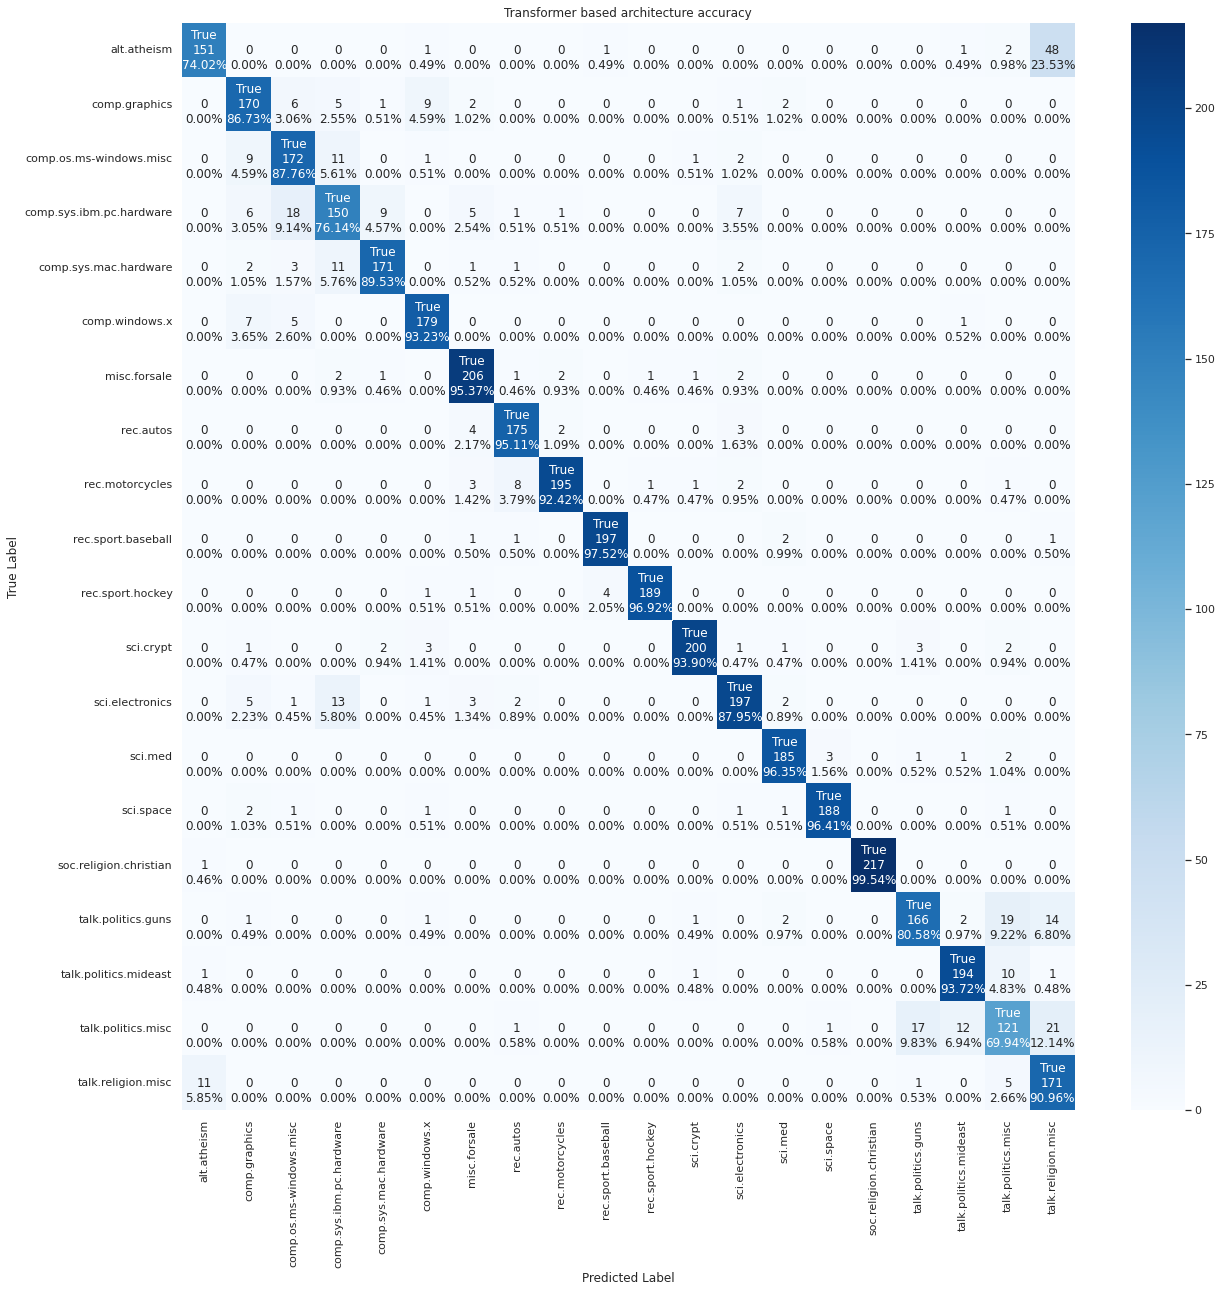

In [ ]:
TF_labels = ['']*len(cf_matrix_bert)*len(cf_matrix_bert)
for i in range(len(cf_matrix_bert)):
  TF_labels[i*20 + i] = 'True'

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_bert.flatten()] 
cmn = cf_matrix_bert.astype('float') / cf_matrix_bert.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(20,20) 
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_bert, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('Transformer based architecture accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(metrics.classification_report(test_names,pred_names))

                          precision    recall  f1-score   support

             alt.atheism       0.92      0.74      0.82       204
           comp.graphics       0.84      0.87      0.85       196
 comp.os.ms-windows.misc       0.83      0.88      0.86       196
comp.sys.ibm.pc.hardware       0.78      0.76      0.77       197
   comp.sys.mac.hardware       0.93      0.90      0.91       191
          comp.windows.x       0.91      0.93      0.92       192
            misc.forsale       0.91      0.95      0.93       216
               rec.autos       0.92      0.95      0.94       184
         rec.motorcycles       0.97      0.92      0.95       211
      rec.sport.baseball       0.98      0.98      0.98       202
        rec.sport.hockey       0.99      0.97      0.98       195
               sci.crypt       0.98      0.94      0.96       213
         sci.electronics       0.90      0.88      0.89       224
                 sci.med       0.95      0.96      0.96       192
         

In [ ]:
#Save the metrics for the final comparison
precision_bert_per_class = cf_matrix_bert.diagonal()/cf_matrix_bert.sum(axis=0)
recall_bert_per_class = cf_matrix_bert.diagonal()/cf_matrix_bert.sum(axis=1)
f1_bert_per_class = 2*(precision_bert_per_class * recall_bert_per_class)/(precision_bert_per_class + recall_bert_per_class)
acc_bert = sum(cf_matrix_bert.diagonal())/cf_matrix_bert.sum()
print(acc_bert)

0.8985


>Plot of the F1 score per class:

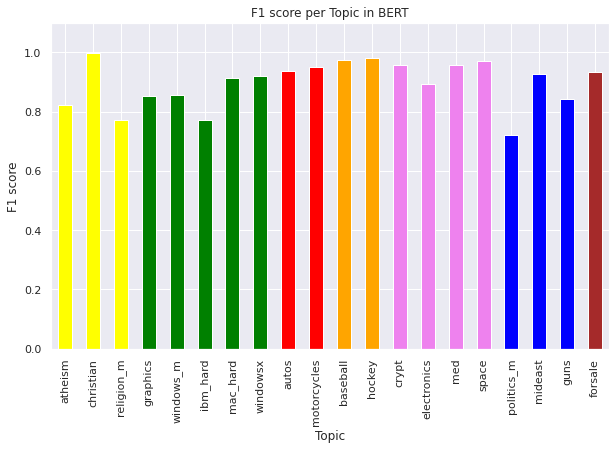

In [ ]:
df_p_bert = pd.DataFrame(list(zip(labels_red, f1_bert_per_class)), columns = ['Topic','f1 score'])
df_p_bert= df_p_bert.reindex([0, 15, 19, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 18, 17, 16,6])
df_p_bert.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), color = cols_clusters, legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in BERT')

plt.show()

>The accuracy on the test set is almost 0.89. There are some categories in which the accuracy is worse, such as atheism and religion misc. We see from the confusion matrix that the model tends to confuse these topics, which makes sense given that they deal with similar elements.

## 5.2. **RoBERTa**

>We now try a different transformers model, which is RoBERTa ( Robustly Optimized BERT Pretraining Approach).
>
> This model aims at improving over BERT performance: in fact, it has been trained on 160GB of data instead of 16.
>
>It does not improve computational time over BERT, but it should, in theory, be able to achieve a superior performance
>
>The parameters used in the training phase will be the same as in the Bert case to have a fair comparison between the models, so we won't repeat ourselves by explaining the reasoning between the choices. The only difference we tried was using a lower learning rate as we read that it could improve performances. However, in the few tests we did (as computation was time-consuming) we could not appreciate such differences and decided to drop this additional training argument.

In [ ]:
model_name = "roberta-base" 

>Load the tokenizer:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_toke

>We use the same training-validation-test split as in the bert base model, we tokenize the dataset and apply padding and truncation. 

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

>We convert our tokenized data into a torch Dataset:

In [ ]:
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)

>We load the model and pass it to CUDA in order to utilize the GPU (fun fact: by trying different training arguments I ran out of available GPU on Colab many times):

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

>Train the model with the same training arguments used for the Bert model:

In [ ]:
random.seed(10)
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,               # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    fp16 = True,                     # to make computation faster
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=200,               # log weights each logging_steps
    save_steps=200,                  # save weights each save_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    seed = 10                       #to ensure reproducibility
)

trainer = Trainer(
    model=model_init(),                  # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
# train the model
trainer.train()

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_model.bin
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

Step,Training Loss,Validation Loss,Accuracy
200,2.893100,2.012443,0.424606
400,1.417500,1.038107,0.668167
600,1.096900,0.901497,0.714179
800,0.901200,0.796770,0.758940
1000,0.834000,0.710388,0.764441
1200,0.701100,0.655627,0.800450
1400,0.584700,0.633083,0.816204
1600,0.566900,0.603986,0.809452
1800,0.538200,0.565929,0.837709
2000,0.490000,0.533481,0.841960


***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3999
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
****

TrainOutput(global_step=3600, training_loss=0.7063960901896159, metrics={'train_runtime': 1565.3748, 'train_samples_per_second': 22.994, 'train_steps_per_second': 2.3, 'total_flos': 5956968482964576.0, 'train_loss': 0.7063960901896159, 'epoch': 3.0})

>The final accuracy obtained on the validation set is around 87%, slightly lower than the one obtained by the Bert base model.
>
>As we did before, we evaluate the model performance on the test set:

In [ ]:
%%capture
# saving the fine tuned model & tokenizer
model = trainer.model
model_path = "20newsgroups-roberta-base"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(target_names)).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_path)

Configuration saved in 20newsgroups-roberta-base/config.json
Model weights saved in 20newsgroups-roberta-base/pytorch_model.bin
tokenizer config file saved in 20newsgroups-roberta-base/tokenizer_config.json
Special tokens file saved in 20newsgroups-roberta-base/special_tokens_map.json
loading configuration file 20newsgroups-roberta-base/config.json
Model config RobertaConfig {
  "_name_or_path": "20newsgroups-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL

In [ ]:
pred_names = []
for i in range(len(test_names)):
  pred_names.append(get_prediction(test_texts[i]))

In [ ]:
cf_matrix_rb = confusion_matrix(test_names, pred_names)

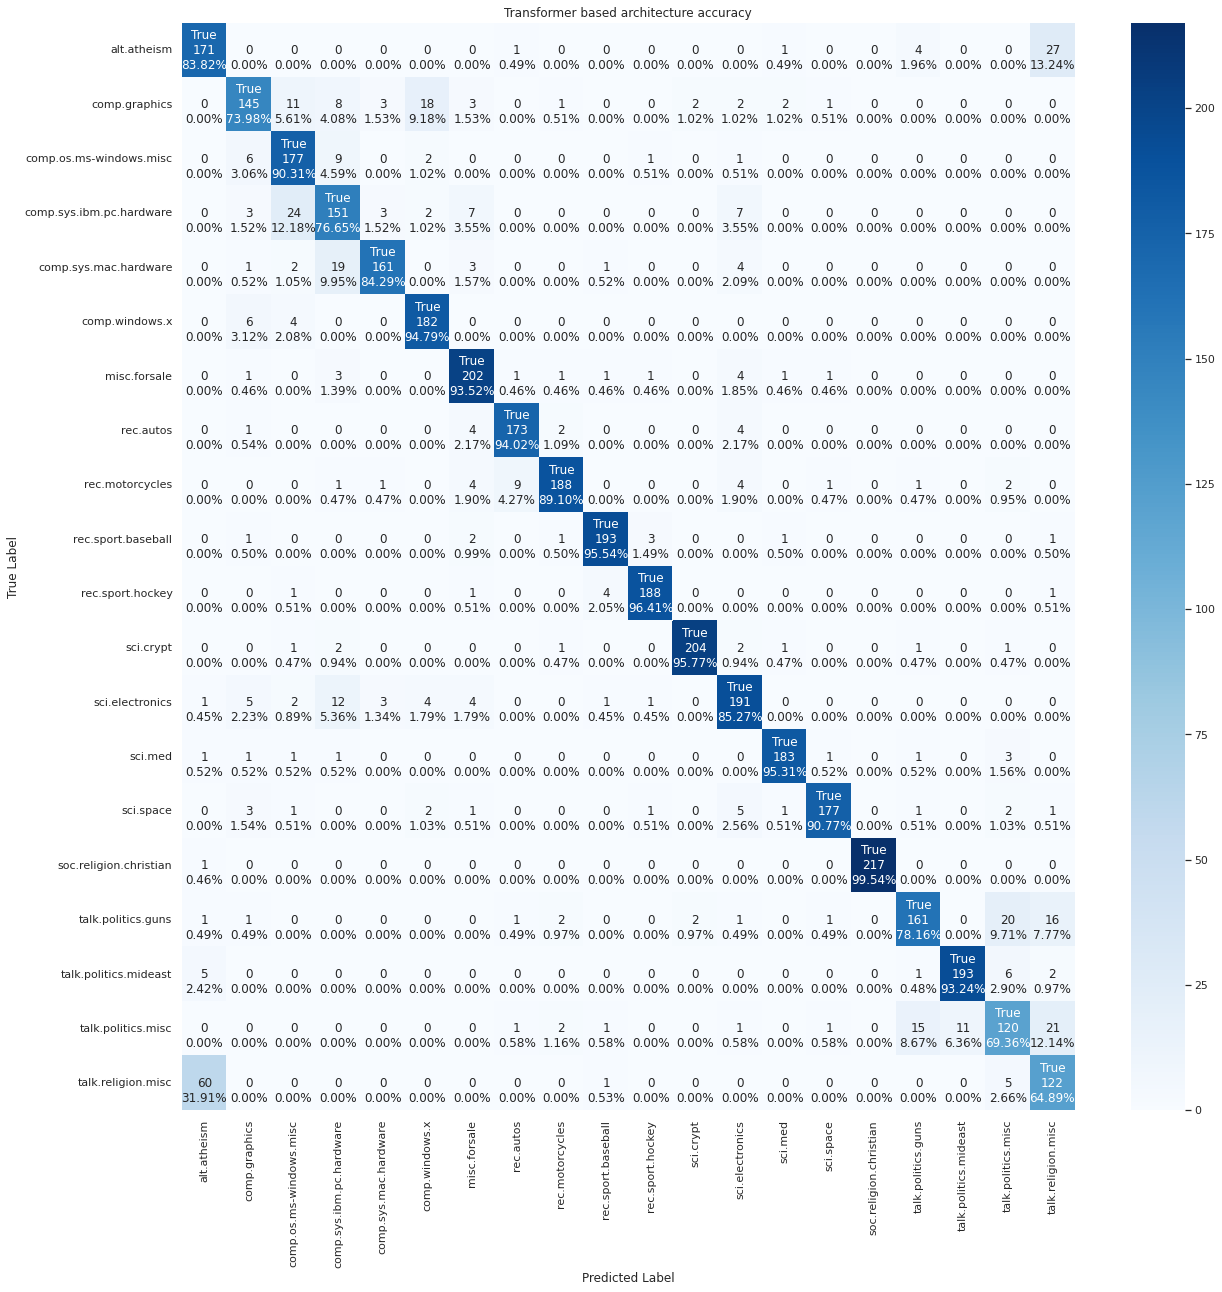

In [ ]:
TF_labels = ['']*len(cf_matrix_rb)*len(cf_matrix_rb)
for i in range(len(cf_matrix_rb)):
  TF_labels[i*20 + i] = 'True'


group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_rb.flatten()] 
cmn = cf_matrix_rb.astype('float') / cf_matrix_rb.sum(axis=1)[:, np.newaxis]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmn.flatten()] 

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(TF_labels, group_counts,group_percentages)] 
labels = np.asarray(labels).reshape(20,20)
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(cf_matrix_rb, annot=labels, fmt='', cmap='Blues', xticklabels=labels2, yticklabels=labels2) 
plt.title('Transformer based architecture accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(metrics.classification_report(test_names,pred_names))

                          precision    recall  f1-score   support

             alt.atheism       0.71      0.84      0.77       204
           comp.graphics       0.83      0.74      0.78       196
 comp.os.ms-windows.misc       0.79      0.90      0.84       196
comp.sys.ibm.pc.hardware       0.73      0.77      0.75       197
   comp.sys.mac.hardware       0.94      0.84      0.89       191
          comp.windows.x       0.87      0.95      0.91       192
            misc.forsale       0.87      0.94      0.90       216
               rec.autos       0.93      0.94      0.94       184
         rec.motorcycles       0.95      0.89      0.92       211
      rec.sport.baseball       0.96      0.96      0.96       202
        rec.sport.hockey       0.96      0.96      0.96       195
               sci.crypt       0.98      0.96      0.97       213
         sci.electronics       0.85      0.85      0.85       224
                 sci.med       0.96      0.95      0.96       192
         

In [ ]:
#Save the metrics for the final comparison
precision_rb_per_class = cf_matrix_rb.diagonal()/cf_matrix_rb.sum(axis=0)
recall_rb_per_class = cf_matrix_rb.diagonal()/cf_matrix_rb.sum(axis=1)
f1_rb_per_class = 2*(precision_rb_per_class * recall_rb_per_class)/(precision_rb_per_class + recall_rb_per_class)
acc_rb = sum(cf_matrix_rb.diagonal())/cf_matrix_rb.sum()
print(acc_rb)

0.87475


>The test accuracy is slightly lower than the one obtained by BERT, despite our expectation, the method which was supposed to be better performed in a similar way, even slightly worse.

>Plot of the F1 score per class:

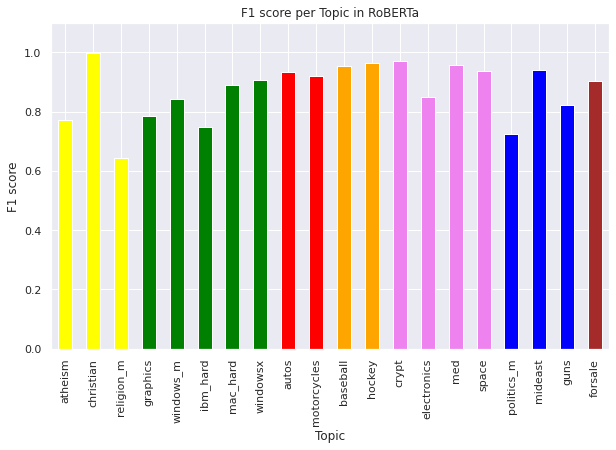

In [ ]:
df_p_rb = pd.DataFrame(list(zip(labels_red, f1_rb_per_class)), columns = ['Topic','f1 score'])
df_p_rb= df_p_rb.reindex([0, 15, 19, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 18, 17, 16,6])
df_p_rb.plot(x = 'Topic', y = 'f1 score', kind='bar', figsize=(10, 6), ylim = (0,1.1), color = cols_clusters, legend = None)
plt.xlabel('Topic')
plt.ylabel('F1 score')
plt.title('F1 score per Topic in RoBERTa')

plt.show()

>The performance on the test set is similar to the one obtained with the Bert Base model, with the same issue faced before about similar topics with which the model tends to make confusion.

# 6. **Model comparison**

> After trying all the methods we described in details before, we can proceed to the final step, which is a final comparison of the models' performances on our data.
>
> First of all we compare them in terms of overall accuracy:

Text(0.5, 1.0, 'Accuracy comparison for the different methods')

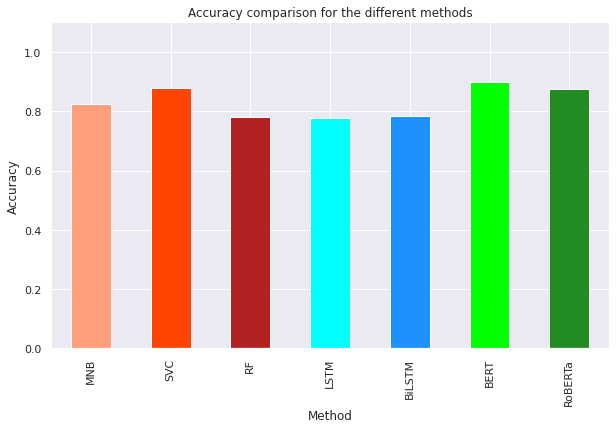

In [ ]:
methods = ["MNB", "SVC", "RF", "LSTM", "BiLSTM","BERT","RoBERTa"]
accuracies = [acc_MNB, acc_SVC, acc_RF, acc_LSTM, acc_biLSTM, acc_bert, acc_rb]
overall_accuracies = pd.DataFrame(list(zip(methods, accuracies)), columns = ['methods', 'accuracies'])
cols_a = ['lightsalmon','orangered','firebrick','aqua','dodgerblue','lime','forestgreen']
overall_accuracies.plot(x = 'methods', y = 'accuracies', kind='bar', figsize=(10, 6), ylim = (0,1.1), color = cols_a, legend = None)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison for the different methods')

>As we can see from the plot, the best performing methods are SVC, BERT and RoBERTa.
>
>However, Transformers method had the issue of the high computational times, while SVC run in few seconds. In general, we can be satisfied with the level of accuracy reached by the best methods, which were near 90% overall. 

> Then we compare the methods in terms of the F1 score distribution for the 20 labels:

In [ ]:
class_f1 = pd.DataFrame(list(zip(labels2, f1_MNB_per_class, f1_SVC_per_class, f1_RF_per_class, f1_LSTM_per_class, f1_biLSTM_per_class, f1_bert_per_class, f1_rb_per_class)), columns =["Label"] + methods)
class_f1.head()

,Label,MNB,SVC,RF,LSTM,BiLSTM,BERT,RoBERTa
0,alt.atheism,0.735823,0.764457,0.701001,0.710921,0.694505,0.820652,0.770270
1,comp.graphics,0.732087,0.824503,0.631111,0.654639,0.589744,0.852130,0.783784
2,comp.os.ms-windows.misc,0.815267,0.846512,0.765507,0.685057,0.725537,0.855721,0.842857
3,comp.sys.ibm.pc.hardware,0.760773,0.795796,0.675119,0.573705,0.645880,0.771208,0.749380
4,comp.sys.mac.hardware,0.828194,0.878837,0.773292,0.654676,0.695652,0.912000,0.889503


Text(0.5, 1.0, 'F1 score comparison for the different methods')

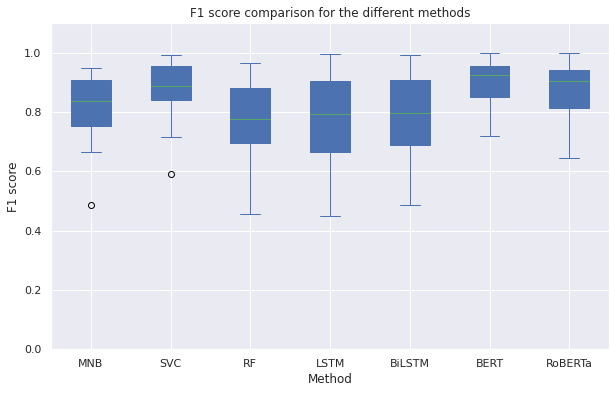

In [ ]:
class_f1.loc[:, class_f1.columns != 'Label'].plot(kind = 'box',figsize=(10, 6), ylim = (0,1.1), patch_artist=True, legend = None)
plt.xlabel('Method')
plt.ylabel('F1 score')
plt.title('F1 score comparison for the different methods')

>This plot allows us to make an additional comparison, regarding how the performance regarding the single classes (measured using the F1 score) is distributed for each of the methods used.
>
>We see that the most dispersed methods are Random Forests, LSTM and BiLSTM, which were also the worst-performing ones. On the other hand, the least dispersed one seems to be BERT, which can then probably be selected to be the best performing model on our data.

>Improvements on our methods are for sure possibile, tuning the parameters more could have yielded a better performance, but we are satisfied about our overall results.